In [631]:
# Import required libraries
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
from scipy.odr import ODR, Model, RealData

## Import ASHRAE Thermal Comfort Database 2

In [724]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_17476/4215538025.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [725]:
# Merge building metadata and measurement data
df_data = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_data.building_id.unique()))
print('Total records:', len(df_data))

Total buildings: 809
Total records: 109033


### Data cleaning

In [726]:
# Merge two outdoor air temperature columns as a new column
df_data.loc[:, 't_out_combined'] = df_data.loc[:, 't_out_isd'].fillna(df_data.loc[:, 't_out'])
# Remove the two outdoor air temperature columns
df_data = df_data.drop(columns=['t_out_isd', 't_out'])

# Keep rows that simultaneously have data for all variables in cols 
def keep_rows(df, cols):
    df_new = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_new['building_id'].unique()), cols)
    print(f'Qualified records:', len(df_new))
    return df_new

In [727]:
cols = ['t_out_combined', 'top', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 553 ['t_out_combined', 'top', 'thermal_sensation']
Qualified records: 38467


In [728]:
df_data.building_type.unique()

array(['office', 'multifamily housing', 'senior center', 'classroom'],
      dtype=object)

In [729]:
# print office buildings
# df_data = df_data[df_data['building_type'] == 'multifamily housing']
print('Multifamily buildings:', len(df_data['building_id'].unique()))
# print('Office buildings:', len(df_data['building_id'].unique()))

Multifamily buildings: 553


## regressing thermal sensation votes against thermal acceptability

In [7]:
# analyze the realtionship between thermal_acceptability and thermal_sensation
df_data['thermal_acceptability'].value_counts()

thermal_acceptability
acceptable      13430
unacceptable     5775
Name: count, dtype: int64

## Estimation result on the first building in the dataset

In [638]:
# neutral temepratuer calculation example
df_data_1bldg = df_data[df_data['building_id'] == 1]
df_data_1bldg

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,165,166,1,1995-08-25T00:00:00Z,winter,16.0,NaN,female,NaN,NaN,...,6.3,-0.25,6.3,18.3,sydney,office,mixed mode,170,1.0,18.862500
166,166,167,1,1995-08-25T00:00:00Z,winter,22.0,NaN,male,NaN,NaN,...,21.2,0.74,16.6,18.3,sydney,office,mixed mode,170,1.0,18.862500
167,167,168,1,1995-08-25T00:00:00Z,winter,4.0,NaN,male,NaN,NaN,...,5.0,0.05,5.0,18.3,sydney,office,mixed mode,170,1.0,18.862500
168,168,169,1,1995-08-25T00:00:00Z,winter,5.0,NaN,male,NaN,NaN,...,6.1,0.23,6.1,18.3,sydney,office,mixed mode,170,1.0,18.862500


In [639]:
len(df_data_1bldg.subject_id.unique())

23

In [640]:
# timestamp start and end of the df_data_1bldg
df_data_1bldg['timestamp'].min(), df_data_1bldg['timestamp'].max()

('1995-05-18T00:00:00Z', '1995-08-25T00:00:00Z')

In [641]:
df_data_1bldg[df_data_1bldg.subject_id==10]

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
14,14,15,1,1995-06-19T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.1,-0.04,5.0,11.3,sydney,office,mixed mode,170,1.0,12.229167
21,21,22,1,1995-06-20T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,16.2,-0.68,14.8,11.4,sydney,office,mixed mode,170,1.0,11.870833
35,35,36,1,1995-06-22T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,7.1,-0.26,6.4,10.7,sydney,office,mixed mode,170,1.0,9.329167
52,52,53,1,1995-06-28T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.1,-0.12,5.3,12.4,sydney,office,mixed mode,170,1.0,15.320833
59,59,60,1,1995-07-25T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.6,0.14,5.4,12.5,sydney,office,mixed mode,170,1.0,10.558333
82,82,83,1,1995-08-15T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.7,NaN,NaN,12.0,sydney,office,mixed mode,170,1.0,13.645833
92,92,93,1,1995-08-16T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,6.3,0.25,6.3,12.5,sydney,office,mixed mode,170,1.0,15.029167
110,110,111,1,1995-08-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.0,NaN,NaN,15.0,sydney,office,mixed mode,170,1.0,19.687500
121,121,122,1,1995-08-21T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,5.4,0.09,5.2,17.4,sydney,office,mixed mode,170,1.0,20.162500


### linear regression method (a)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_17476/2221830064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])


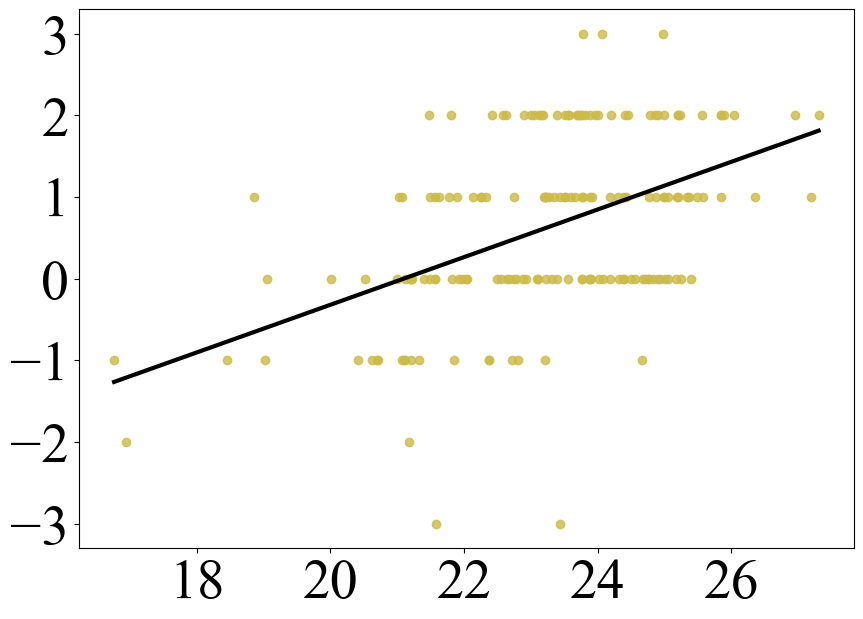

Neutral temperature is 21.1 degree Celsius.
80 percent acceptable temperature range is (18.2 ~ 24.0) degree Celsius.
90 percent acceptable temperature range is (19.4 ~ 22.8) degree Celsius.
p value: 1.2974572985470425e-10
                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.30e-10
Time:                        16:05:57   Log-Likelihood:                -237.80
No. Observations:                 169   AIC:                             479.6
Df Residuals:                     167   BIC:                             485.9
Df Model:                           1                                         
Covariance Type:            nonrobust                              

In [642]:

# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='thermal_sensation ~ top', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black','linewidth': 3}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
# plt.title('Regress thermal sensation votes on indoor temperature')
# change the font to sen-serif Times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.06, 0.8)
# alighn label right in the text box
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels

plt.grid(False)

plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['top'] < 0.05:
    a = lm_result.params['top']
    b = lm_result.params['Intercept']
    neutral_temp = -b / a
    temp80_up = (0.85-b)/a
    temp80_low = (-0.85-b)/a
    temp90_up = (0.5-b)/a
    temp90_low = (-0.5-b)/a
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))
else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['top'])
print(lm_result.summary())

total least square method a

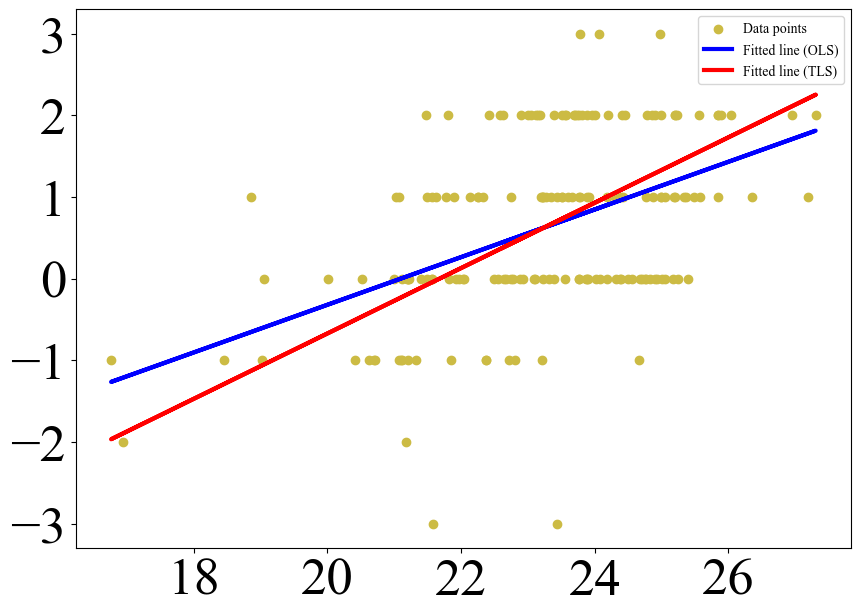

In [643]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.odr import ODR, Model, RealData
import statsmodels.formula.api as smf

# Sample data points
x = df_data_1bldg['top'].to_numpy()
y = df_data_1bldg['thermal_sensation'].to_numpy()

# OLS regression
slope_ols, intercept_ols, _, _, _ = stats.linregress(x, y)

# Define the model function for the orthogonal regression
def linear_func(B, x):
    return B[0] * x + B[1]

# Create a RealData object with the data points
data = RealData(x, y)

# Create a Model object with the model function
model = Model(linear_func)

# Create an ODR object with the data, model, and an initial guess for the parameters
odr = ODR(data, model, beta0=[1, 0])

# Run the orthogonal regression
output = odr.run()

# Plot the data points and fitted lines
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='#CCBB44', label='Data points')
plt.plot(x, slope_ols * x + intercept_ols, color='blue', linewidth=3, label='Fitted line (OLS)')
plt.plot(x, linear_func(output.beta, x), color='red', linewidth=3, label='Fitted line (TLS)')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# Additional plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
plt.grid(False)
plt.legend()

# Show the plot
plt.show()


In [644]:
# calcualte the neutral temperature of TLS regression line
a = output.beta[0]
b = output.beta[1]
neutral_temp = -b / a
temp80_up = (0.85-b)/a
temp80_low = (-0.85-b)/a
temp90_up = (0.5-b)/a
temp90_low = (-0.5-b)/a
print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))


Neutral temperature is 21.7 degree Celsius.
80 percent acceptable temperature range is (19.5 ~ 23.8) degree Celsius.
90 percent acceptable temperature range is (20.4 ~ 22.9) degree Celsius.


total least square method b

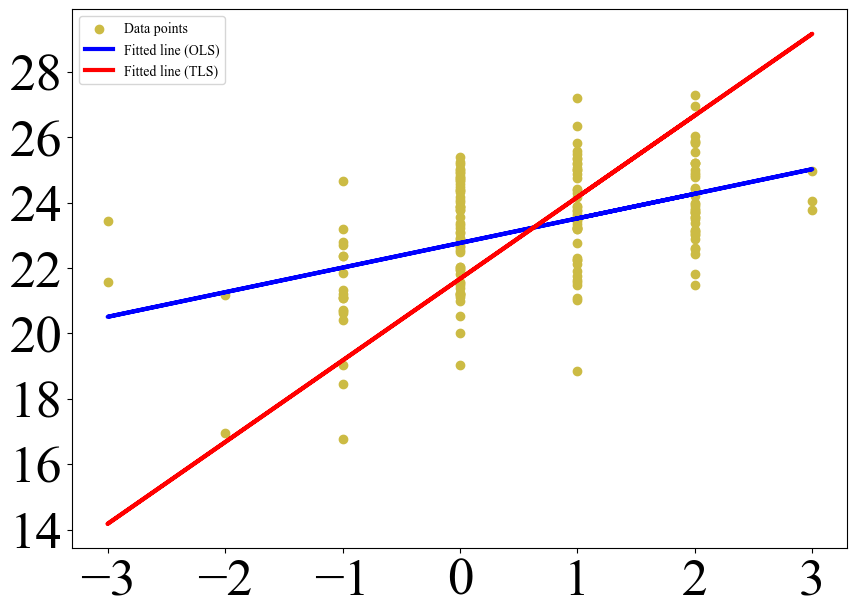

In [645]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.odr import ODR, Model, RealData
import statsmodels.formula.api as smf

# Sample data points
x = df_data_1bldg['thermal_sensation'].to_numpy()
y = df_data_1bldg['top'].to_numpy()

# OLS regression
slope_ols, intercept_ols, _, _, _ = stats.linregress(x, y)

# Define the model function for the orthogonal regression
def linear_func(B, x):
    return B[0] * x + B[1]

# Create a RealData object with the data points
data = RealData(x, y)

# Create a Model object with the model function
model = Model(linear_func)

# Create an ODR object with the data, model, and an initial guess for the parameters
odr = ODR(data, model, beta0=[1, 0])

# Run the orthogonal regression
output = odr.run()

# Plot the data points and fitted lines
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='#CCBB44', label='Data points')
plt.plot(x, slope_ols * x + intercept_ols, color='blue', linewidth=3, label='Fitted line (OLS)')
plt.plot(x, linear_func(output.beta, x), color='red', linewidth=3, label='Fitted line (TLS)')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# Additional plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
plt.grid(False)
plt.legend()

# Show the plot
plt.show()


In [646]:
# calcualte the neutral temperature of TLS regression line
a = output.beta[0]
b = output.beta[1]
neutral_temp = b
temp80_up = 0.85*a +b
temp80_low = -0.85*a +b
temp90_up = 0.5*a +b
temp90_low = -0.5*a +b
print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))


Neutral temperature is 21.7 degree Celsius.
80 percent acceptable temperature range is (19.5 ~ 23.8) degree Celsius.
90 percent acceptable temperature range is (20.4 ~ 22.9) degree Celsius.



### linear regression method (b)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_17476/2407091455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])


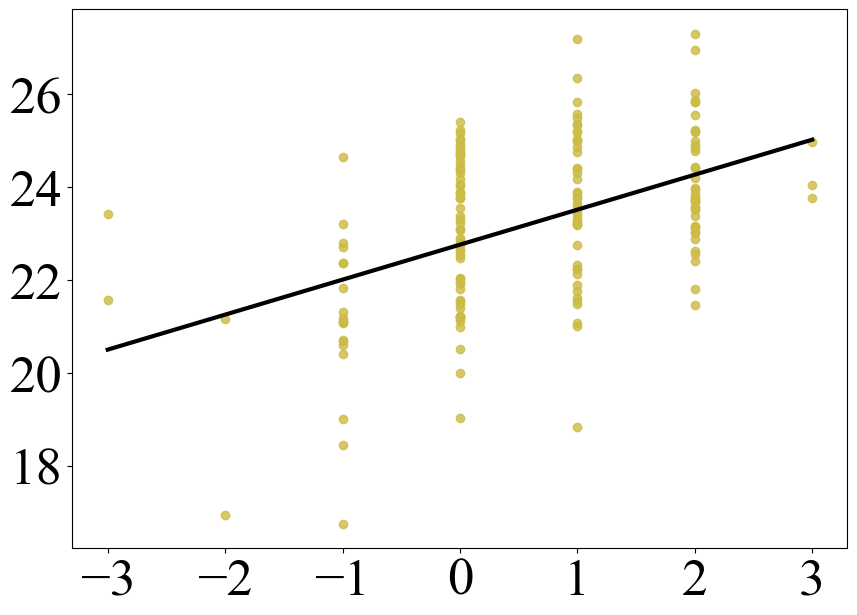

Neutral temperature is 22.8 degree Celsius.
80 percent acceptable temperature range is (22.1 ~ 23.4) degree Celsius.
90 percent acceptable temperature range is (22.4 ~ 23.1) degree Celsius.
p value: 1.2974572985469008e-10
                            OLS Regression Results                            
Dep. Variable:                    top   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.30e-10
Time:                        16:06:12   Log-Likelihood:                -317.89
No. Observations:                 169   AIC:                             639.8
Df Residuals:                     167   BIC:                             646.0
Df Model:                           1                                         
Covariance Type:            nonrobust                              

In [647]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='top ~ thermal_sensation', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])
# plot the regression line, don't show the confidence interval
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)

plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# plt.title('Regress thermal sensation votes on indoor temperature')
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.72)
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=38)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=38)  # Set font size for y-axis tick labels

plt.grid(False)

plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    neutral_temp = b
    temp80_up = 0.85*a + b
    temp80_low = (-0.85)*a + b
    temp90_up = 0.5*a + b
    temp90_low = (-0.5)*a + b
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))

else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['thermal_sensation'])
print(lm_result.summary())

### two methods have the same pearson correlation coefficient

In [648]:
# calculate pearson correlation coefficient
df_data_1bldg[['top', 'thermal_sensation']].corr()

,top,thermal_sensation
top,1.000000,0.468746
thermal_sensation,0.468746,1.000000


## Estimation results on every building in the dataset

### Two linear regression functions

In [730]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = slope
            b = intercept
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### estimation for all buildings

In [786]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office


In [787]:
len(df_bldg)

553

In [788]:
# calculate all temperature values for each building
columns_name = ['slope', 'intercept', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

# calculate the mean of the absolute difference between t_80_up_a and t_80_low_a
df_bldg['t_80_diff_a'] = df_bldg['t_80_up_a'] - df_bldg['t_80_low_a']
df_bldg['t_80_diff_b'] = df_bldg['t_80_up_b'] - df_bldg['t_80_low_b']

df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office,0.291819,0.752942,-6.154552,22.767420,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,5.825536,1.280002
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office,0.706530,0.317700,-15.816544,22.306879,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,2.406125,0.540090
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office,0.504547,0.495382,-11.992110,23.922257,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,3.369362,0.842150
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [734]:
len(df_bldg)

553

In [795]:
# number of naturally ventilated buildings
print("total NV", len(df_bldg[df_bldg['cooling_type'] == 'Naturally Ventilated']))
# number of naturally ventilated buildings
print("total AC ", len(df_bldg[df_bldg['cooling_type'] == 'Air Conditioned']))

total NV 216
total AC  163


### skip (MSE for each buliding)

In [875]:
df_bldg

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office,0.291819,0.752942,-6.154552,22.767420,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,5.825536,1.280002
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office,0.706530,0.317700,-15.816544,22.306879,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,2.406125,0.540090
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office,0.504547,0.495382,-11.992110,23.922257,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,3.369362,0.842150
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,737,24.316162,25.010101,28.469928,99,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549,738,24.202332,24.372798,28.905322,387,Air Conditioned,office,0.121583,0.087743,-3.870064,24.452358,31.830522,24.452358,38.821606,24.526939,24.839438,24.377776,13.982168,0.149163
550,739,22.957143,23.000000,25.815476,56,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,classroom,0.232627,0.318970,-4.690074,22.809739,20.161369,22.809739,23.815291,23.080864,16.507447,22.538615,7.307844,0.542249


In [877]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate NRMSE
def nrmse(y_true, y_pred):
    range_of_values = y_true.max() - y_true.min()
    return rmse(y_true, y_pred) / range_of_values if range_of_values != 0 else None

# Calculate NRMSE for each building
for i, row in df_bldg.iterrows():
    # Step 1: Filter df_data for the building
    building_data = df_data[df_data['building_id'] == row['building_id']]
    
    # Step 2: Extract 'thermal_sensation' and 'top' columns
    tsv = building_data['thermal_sensation']
    top = building_data['top']
    
    # Step 3: Calculate predicted values for method A
    if pd.notna(row['slope_a']) and pd.notna(row['intercept_a']):
        y_pred_a = row['slope_a'] * top + row['intercept_a']
        
        # Step 4: Calculate NRMSE for method A
        nrmse_a = nrmse(tsv, y_pred_a)
    else:
        nrmse_a = None
    
    # Step 5: Repeat steps 3-4 for method B
    if pd.notna(row['slope_b']) and pd.notna(row['intercept_b']):
        y_pred_b = row['slope_b'] * tsv + row['intercept_b']
        
        # Step 6: Calculate NRMSE for method B
        nrmse_b = nrmse(top, y_pred_b)
    else:
        nrmse_b = None
    
    # Store the NRMSE values in df_bldg
    df_bldg.at[i, 'nrmse_a'] = nrmse_a
    df_bldg.at[i, 'nrmse_b'] = nrmse_b

# Now df_bldg has two new columns 'nrmse_a' and 'nrmse_b' containing the NRMSE values for method A and B for each building.

# Sum nrmse_a and nrmse_b for all buildings that achieve statistical significance
print(df_bldg['nrmse_a'].sum())
print(df_bldg['nrmse_b'].sum())

40.42938151479954
44.030181489219075


In [65]:
### a temperory neutral temperature calculation furnction for including non statistical significant buildings
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        a = lm_result.params['top']
        b = lm_result.params['Intercept']
        n_t = -b / a
        t_80_up = (0.85-b)/a
        t_80_low = (-0.85-b)/a
        t_90_up = (0.5-b)/a
        t_90_low = (-0.5-b)/a
        return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        a = lm_result.params['thermal_sensation']
        b = lm_result.params['Intercept']
        n_t = b
        t_80_up = 0.85*a + b
        t_80_low = (-0.85)*a + b
        t_90_up = 0.5*a + b
        t_90_low = (-0.5)*a + b
        return [slope, intercept, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
    except (ValueError, TypeError):
        return np.nan

In [71]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,building_type
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office


In [72]:
# calculate all temperature values for each building
columns_name = ['slope', 'intercept', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:9: RuntimeWarning: invalid value encountered in scalar divide
  n_t = -b / a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  t_80_up = (0.85-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  t_80_low = (-0.85-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  t_90_up = (0.5-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  t_90_low = (-0.5-b)/a
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_26534/1619233051.py:9: RuntimeWarning: invalid value encountered in scalar divide
  n_t = -b / a
/var/folders/v0/03v41t

In [73]:
df_bldg

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,office,0.291819,0.752942,-6.154552,22.767420,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,office,0.706530,0.317700,-15.816544,22.306879,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,office,0.047597,0.013208,-0.850281,23.174896,17.864050,23.174896,35.722188,23.186122,0.005913,23.163670
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,office,0.504547,0.495382,-11.992110,23.922257,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,office,0.161458,0.137435,-3.630748,22.104007,22.487246,22.104007,27.751771,22.220827,17.222722,21.987187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,737,24.316162,25.010101,28.469928,99,Air Conditioned,office,0.079583,0.279189,-2.727761,25.215968,34.275529,25.215968,44.956156,25.453278,23.594902,24.978657
549,738,24.202332,24.372798,28.905322,387,Air Conditioned,office,0.121583,0.087743,-3.870064,24.452358,31.830522,24.452358,38.821606,24.526939,24.839438,24.377776
550,739,22.957143,23.000000,25.815476,56,Air Conditioned,office,0.133929,0.331579,-4.794643,23.568421,35.800000,23.568421,42.146667,23.850263,29.453333,23.286579
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,classroom,0.232627,0.318970,-4.690074,22.809739,20.161369,22.809739,23.815291,23.080864,16.507447,22.538615


In [74]:
# calcualte MSE for each building
for i, row in df_bldg.iterrows():
    # Step 1: Filter df_data for the building
    building_data = df_data[df_data['building_id'] == row['building_id']]
    
    # Step 2: Extract 'thermal_sensation' and 'top' columns
    # y_true = building_data['thermal_sensation']
    tsv = building_data['thermal_sensation']
    top = building_data['top']
    
    # Step 3: Calculate predicted values for method A
    if pd.notna(row['slope_a']) and pd.notna(row['intercept_a']):
        y_pred_a = row['slope_a'] * top + row['intercept_a']
        
        # Step 4: Calculate MSE for method A
        mse_a = mean_squared_error(tsv, y_pred_a)
    else:
        mse_a = None
    
    # Step 5: Repeat steps 3-4 for method B
    if pd.notna(row['slope_b']) and pd.notna(row['intercept_b']):
        y_pred_b = row['slope_b'] * tsv + row['intercept_b']
        
        # Step 6: Calculate MSE for method B
        mse_b = mean_squared_error(top, y_pred_b)
    else:
        mse_b = None
    
    # Store the MSE values in df_bldg
    df_bldg.at[i, 'mse_a'] = mse_a
    df_bldg.at[i, 'mse_b'] = mse_b

# Now df_bldg has two new columns 'mse_a' and 'mse_b' containing the MSE values for method A and B for each building.


In [75]:
# sum mse_a and mse_b for all buildings including non statistical significance
print(df_bldg['mse_a'].sum())
print(df_bldg['mse_b'].sum())

319.3962620488572
1215.1328595970879


### does a negative relationship reasonable?

In [582]:
# identify less than 0 values in slope_a and slope_b
# df_bldg[df_bldg['slope_a'] < 0]
df_bldg[df_bldg['slope_b'] < 0]

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b
13,14,19.157143,19.213985,7.250000,16,Air Conditioned,office,NaN,-0.063962,NaN,19.236829,NaN,19.236829,NaN,19.182461,NaN,19.291196,NaN,-0.108735
15,16,22.422222,22.609449,5.008333,9,Air Conditioned,office,NaN,-0.020101,NaN,22.629551,NaN,22.629551,NaN,22.612465,NaN,22.646636,NaN,-0.034172
16,17,20.542857,20.648680,8.841667,7,Air Conditioned,office,NaN,-0.123297,NaN,20.754363,NaN,20.754363,NaN,20.649561,NaN,20.859166,NaN,-0.209604
20,21,22.831765,23.055791,11.820833,17,Air Conditioned,office,NaN,-0.155596,NaN,23.259896,NaN,23.259896,NaN,23.127640,NaN,23.392153,NaN,-0.264513
22,23,21.609308,21.713359,13.445833,53,Air Conditioned,office,NaN,-0.141045,NaN,21.763123,NaN,21.763123,NaN,21.643235,NaN,21.883011,NaN,-0.239776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,507,14.350000,14.540000,8.300000,2,NaN,multifamily housing,NaN,-5.816000,NaN,2.908000,NaN,2.908000,NaN,-2.035600,NaN,7.851600,NaN,-9.887200
466,518,15.250000,15.535000,12.420000,2,NaN,multifamily housing,NaN,-7.767500,NaN,7.767500,NaN,7.767500,NaN,1.165125,NaN,14.369875,NaN,-13.204750
470,522,16.550000,16.955000,16.040000,2,NaN,multifamily housing,NaN,-8.477500,NaN,8.477500,NaN,8.477500,NaN,1.271625,NaN,15.683375,NaN,-14.411750
517,583,18.509091,18.581818,14.201705,11,Air Conditioned,office,NaN,-0.207407,NaN,18.355556,NaN,18.355556,NaN,18.179259,NaN,18.531852,NaN,-0.352593


### visualize negative ones

Text(0, 0.5, '')

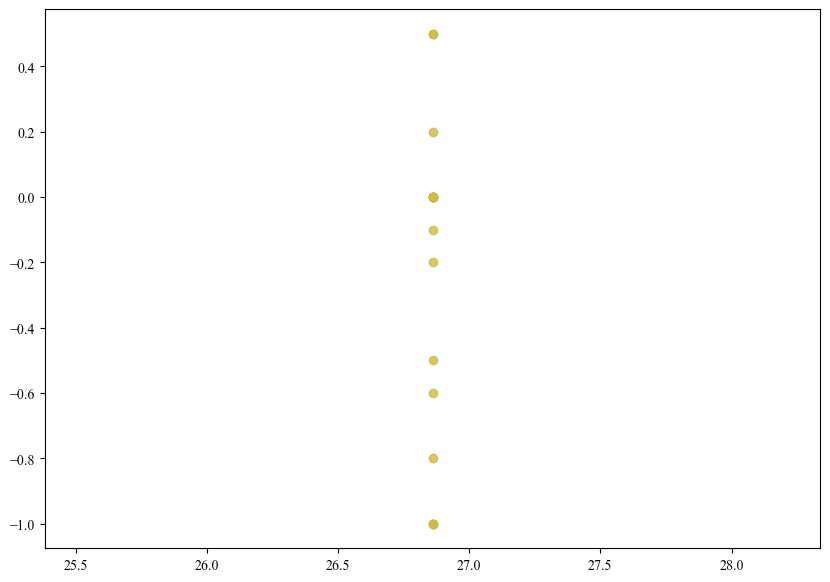

In [88]:
# scatter plot thermal sensation votes against indoor temperature of 65 and 155 building id
df_data_65 = df_data[df_data['building_id'] == 65]
df_data_155 = df_data[df_data['building_id'] == 155]

# plot the regression line, don't show the confidence interval
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_155, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

In [89]:
df_bldg[df_bldg['cooling_type'] == 'Naturally Ventilated'][df_bldg['slope_b'] < 0]

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_17476/1314850384.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bldg[df_bldg['cooling_type'] == 'Naturally Ventilated'][df_bldg['slope_b'] < 0]


,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b
64,65,26.114286,26.130612,22.820408,49,Naturally Ventilated,office,-0.856490,-3.024334e-01,22.345918,26.120120,26.090105,26.120120,25.097683,25.863051,27.082528,26.377188,-1.984845,-5.141369e-01
154,155,27.188333,26.860208,27.579167,20,Naturally Ventilated,office,-0.009295,-5.329071e-15,-0.000346,26.860208,-0.037230,26.860208,-91.488518,26.860208,91.414058,26.860208,-182.902576,-7.105427e-15
160,161,22.777235,23.627738,24.691667,68,Naturally Ventilated,office,NaN,-2.199705e-02,NaN,23.615769,NaN,23.615769,NaN,23.597072,NaN,23.634467,NaN,-3.739499e-02
165,172,31.352632,31.394608,29.904971,190,Naturally Ventilated,office,NaN,-1.185989e-01,NaN,31.453283,NaN,31.453283,NaN,31.352474,NaN,31.554092,NaN,-2.016182e-01
231,732,26.674194,26.522581,21.391705,31,Naturally Ventilated,office,NaN,-9.431818e-02,NaN,26.559091,NaN,26.559091,NaN,26.478920,NaN,26.639261,NaN,-1.603409e-01


Text(0, 0.5, '')

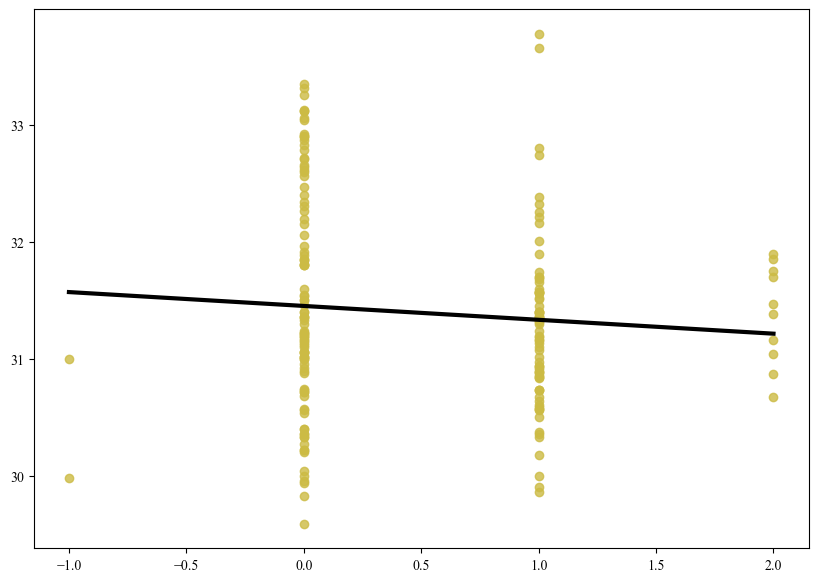

In [101]:
# scatter plot thermal sensation votes against indoor temperature of 65 and 155 building id
df_data_155 = df_data[df_data['building_id'] == 172]

# plot the regression line, don't show the confidence interval
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_155, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

### remove negative ones

In [796]:
# create a buliding id list for buildings with negative slope_a or slope_b
bldg_id_neg = df_bldg[(df_bldg['slope_a'] < 0) | (df_bldg['slope_b'] < 0)]['building_id'].tolist()
# remove the buildings of bldg_id_neg from df_bldg
df_bldg = df_bldg[~df_bldg['building_id'].isin(bldg_id_neg)].copy()

In [797]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]

print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

df_bldg_ac_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_a))

df_bldg_re_a = df_bldg_nv_a[df_bldg_nv_a['building_type'] == 'multifamily housing']
print('number of multi-family & NV buildings that have statistical significant neutral temperature:', len(df_bldg_re_a))

df_bldg_off_a = df_bldg_nv_a[df_bldg_nv_a['building_type'] == 'office']
print('number of office & NV buildings that have statistical significant neutral temperature:', len(df_bldg_off_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 210
number of naturally ventilated buildings that have statistical significant neutral temperature: 70
number of air conditioned buildings that have statistical significant neutral temperature: 85
number of multi-family & NV buildings that have statistical significant neutral temperature: 19
number of office & NV buildings that have statistical significant neutral temperature: 49


In [798]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]

print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))

df_bldg_ac_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_b))

df_bldg_re_b = df_bldg_nv_b[df_bldg_nv_b['building_type'] == 'multifamily housing']
print('number of multi-family % NV buildings that have statistical significant neutral temperature:', len(df_bldg_re_b))

df_bldg_off_b = df_bldg_nv_b[df_bldg_nv_b['building_type'] == 'office']
print('number of office & NV buildings that have statistical significant neutral temperature:', len(df_bldg_off_b))


regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 215
number of naturally ventilated buildings that have statistical significant neutral temperature: 73
number of air conditioned buildings that have statistical significant neutral temperature: 86
number of multi-family % NV buildings that have statistical significant neutral temperature: 22
number of office & NV buildings that have statistical significant neutral temperature: 49


## visualize the number of stats significatn results

In [791]:
# create a new dataframe that doesn't have classroom or senior center buildings or mixed mode buildings
df_bldg_stat = df_bldg[~df_bldg['building_type'].isin(['classroom', 'senior center'])]
df_bldg_stat = df_bldg_stat[~df_bldg_stat['cooling_type'].isin(['Mixed Mode'])]


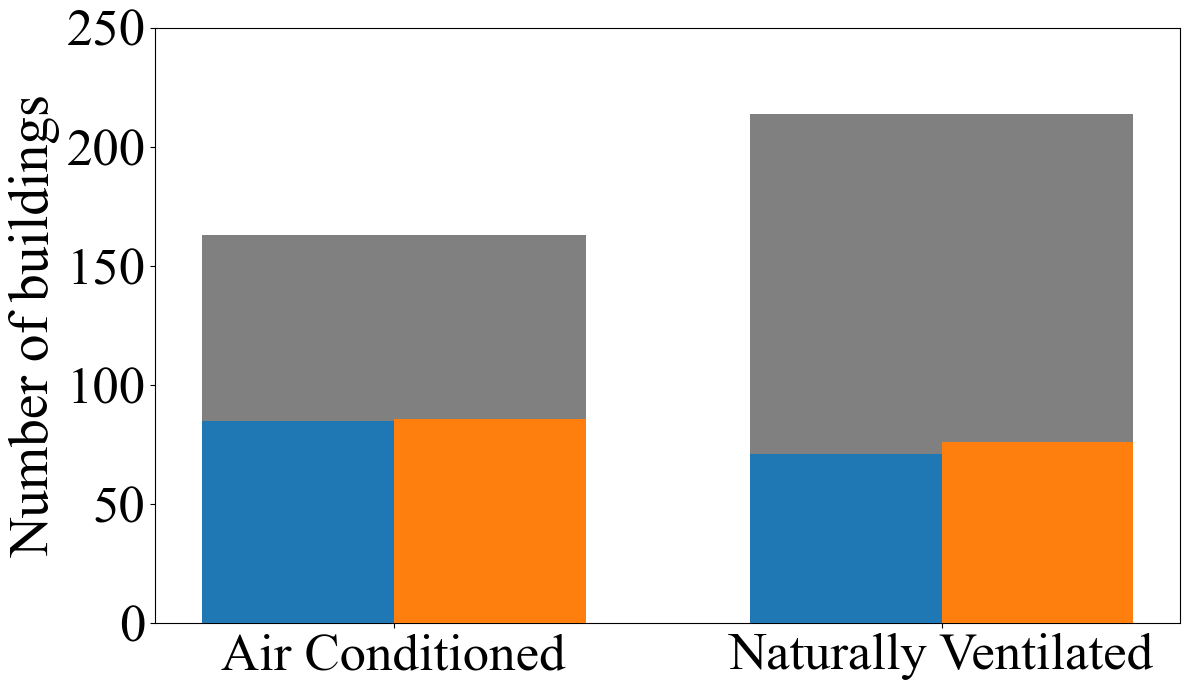

In [792]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_bldg_stat is your DataFrame and it's already been loaded

# Count non-NaN values for n_t_a and n_t_b within each cooling type group
cooling_non_nan_counts = df_bldg_stat.groupby('cooling_type').agg({
    'n_t_a': lambda x: x.notna().sum(),
    'n_t_b': lambda x: x.notna().sum(),
}).reset_index()

# Count NaN values for n_t_a and n_t_b within each cooling type group
cooling_nan_counts = df_bldg_stat.groupby('cooling_type').agg({
    'n_t_a': lambda x: x.isna().sum(),
    'n_t_b': lambda x: x.isna().sum(),
}).reset_index()

# Count the total number of buildings per cooling type
cooling_total_counts = df_bldg_stat.groupby('cooling_type')['building_id'].count().reset_index(name='total')

# Merge the counts into a single DataFrame
cooling_counts = pd.merge(cooling_non_nan_counts, cooling_nan_counts, on='cooling_type', suffixes=('_non_nan', '_nan'))
cooling_counts = pd.merge(cooling_counts, cooling_total_counts, on='cooling_type')

# Plot the counts in a bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Create bar positions for each cooling type
bar_width = 0.35
index = np.arange(len(cooling_counts))

# Plot bars for non-NaN values
bar1 = ax.bar(index, cooling_counts['n_t_a_non_nan'], bar_width, label='n_t_a Non-NaN', zorder=3)
bar2 = ax.bar(index + bar_width, cooling_counts['n_t_b_non_nan'], bar_width, label='n_t_b Non-NaN', zorder=3)

# Plot bars for NaN values on top of non-NaN values
bar3 = ax.bar(index, cooling_counts['n_t_a_nan'], bar_width, bottom=cooling_counts['n_t_a_non_nan'],
              label='n_t_a NaN', color='grey', zorder=2)
bar4 = ax.bar(index + bar_width, cooling_counts['n_t_b_nan'], bar_width, bottom=cooling_counts['n_t_b_non_nan'],
              label='n_t_b NaN', color='grey', zorder=2)

# Function to attach a text label above each bar
def autolabel(bars):
    """Attach a text label above each bar displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to label the bars
# autolabel(bar1)
# autolabel(bar2)
# autolabel(bar3)
# autolabel(bar4)

# Add labels and title
# ax.set_xlabel('Cooling Type')
ax.set_ylabel('Number of buildings', fontsize=40)
# ax.set_title('Count of Non-NaN and NaN Values for n_t_a and n_t_b by Cooling Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cooling_counts['cooling_type'])
# ax.legend()
plt.xticks(fontsize=38)  # Rotate and set font size for x-axis tick labels
plt.yticks([0, 50, 100, 150, 200, 250], fontsize=38)  # Set font size for y-axis tick labels
# Display the plot
plt.savefig('statAC.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()


In [793]:
df_bldg_ac = df_bldg_stat[df_bldg_stat['cooling_type'] == 'Air Conditioned']
df_bldg_nv = df_bldg_stat[df_bldg_stat['cooling_type'] == 'Naturally Ventilated']

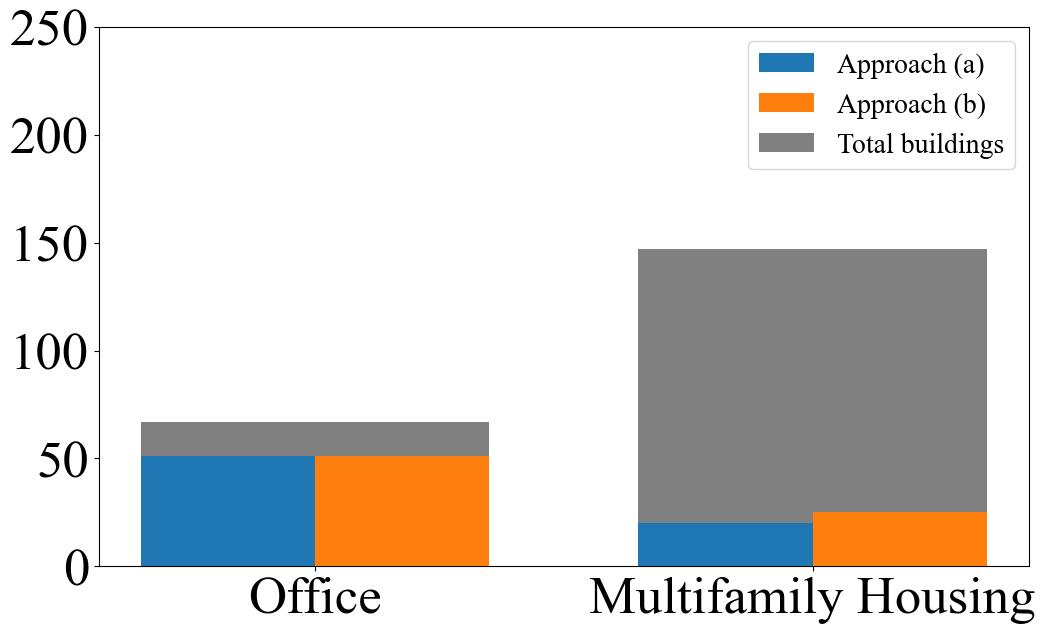

In [794]:
# Assuming df_bldg_nv is your DataFrame and it's already been loaded

# Count non-NaN values for n_t_a and n_t_b within each building type group
building_non_nan_counts = df_bldg_nv.groupby('building_type').agg({
    'n_t_a': lambda x: x.notna().sum(),
    'n_t_b': lambda x: x.notna().sum(),
}).reset_index()

# Count NaN values for n_t_a and n_t_b within each building type group
building_nan_counts = df_bldg_nv.groupby('building_type').agg({
    'n_t_a': lambda x: x.isna().sum(),
    'n_t_b': lambda x: x.isna().sum(),
}).reset_index()

# Count the total number of buildings per building type
building_total_counts = df_bldg_nv.groupby('building_type')['building_id'].count().reset_index(name='total')

# Merge the counts into a single DataFrame
building_counts = pd.merge(building_non_nan_counts, building_nan_counts, on='building_type', suffixes=('_non_nan', '_nan'))
building_counts = pd.merge(building_counts, building_total_counts, on='building_type')

# Add a sorting key column to prioritize 'office'
building_counts['sort_key'] = building_counts['building_type'] == 'office'

# Sort the counts so that 'office' is first
building_counts_sorted = building_counts.sort_values(by='sort_key', ascending=False).drop('sort_key', axis=1)

# Plot the counts in a bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Create bar positions for each building type
bar_width = 0.35
index = np.arange(len(building_counts_sorted))

# Plot bars for non-NaN values
bar1 = ax.bar(index, building_counts_sorted['n_t_a_non_nan'], bar_width, label='Approach (a)', zorder=3)
bar2 = ax.bar(index + bar_width, building_counts_sorted['n_t_b_non_nan'], bar_width, label='Approach (b)', zorder=3)

# Plot bars for NaN values on top of non-NaN values
bar3 = ax.bar(index, building_counts_sorted['n_t_a_nan'], bar_width, bottom=building_counts_sorted['n_t_a_non_nan'], label='Total buildings', color='grey', zorder=2)
bar4 = ax.bar(index + bar_width, building_counts_sorted['n_t_b_nan'], bar_width, bottom=building_counts_sorted['n_t_b_non_nan'], color='grey', zorder=2)

# Set the labels for the x-ticks manually
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Office", "Multifamily Housing"], rotation=0)  # Setting the labels manually

# Add labels and title
# ax.set_xlabel('Building Type')
# ax.set_title('Count of Non-NaN and NaN Values for n_t_a and n_t_b by Building Type')
# Set the labels for the x-ticks

plt.xticks(fontsize=38)  # Rotate and set font size for x-axis tick labels
plt.yticks([0, 50, 100, 150, 200, 250], fontsize=38)  # Set font size for y-axis tick labels
# Display the legend on top right of the plot
ax.legend(loc='upper right', fontsize=20)
plt.savefig('statoffice.pdf', format='pdf', bbox_inches='tight')


## timestap visualization

In [282]:
df_data

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18 00:00:00+00:00,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18 00:00:00+00:00,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18 00:00:00+00:00,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18 00:00:00+00:00,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18 00:00:00+00:00,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103773,104809,104810,781,2012-04-20 00:00:00+00:00,winter,NaN,NaN,NaN,NaN,NaN,...,5.8,-0.20,5.8,4.4,hampshire,classroom,naturally ventilated,748,2.0,5.991667
103774,104810,104811,781,2012-04-20 00:00:00+00:00,winter,NaN,NaN,NaN,NaN,NaN,...,5.8,-0.20,5.8,4.4,hampshire,classroom,naturally ventilated,748,2.0,5.991667
103775,104811,104812,781,2012-04-20 00:00:00+00:00,winter,NaN,NaN,NaN,NaN,NaN,...,5.8,-0.20,5.8,4.4,hampshire,classroom,naturally ventilated,748,2.0,5.991667
103776,104812,104813,781,2012-04-20 00:00:00+00:00,winter,NaN,NaN,NaN,NaN,NaN,...,16.3,-0.73,16.3,4.4,hampshire,classroom,naturally ventilated,748,2.0,5.991667


In [283]:
df_bldg

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,...,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b,timestamp_min,timestamp_max,timestamp_diff
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,classroom,0.232627,0.318970,-4.690074,...,22.809739,23.815291,23.080864,16.507447,22.538615,7.307844,0.542249,1994-11-29 00:00:00+00:00,1994-11-29 00:00:00+00:00,0 days
533,623,24.190335,24.123471,16.913373,1042,Naturally Ventilated,office,0.304509,0.768177,-6.914854,...,23.792413,25.499566,24.445363,19.916813,23.139463,5.582753,1.305900,1987-03-30 00:00:00+00:00,1987-04-03 00:00:00+00:00,4 days
534,624,22.759326,22.866629,12.089942,938,Naturally Ventilated,office,0.186973,0.477411,-4.229364,...,22.844636,27.166365,23.250435,18.074121,22.438837,9.092244,0.811598,1987-01-05 00:00:00+00:00,1987-01-09 00:00:00+00:00,4 days
535,671,22.627749,22.647826,10.449488,782,Mixed Mode,office,0.130995,0.274861,-3.062663,...,22.674187,29.868766,22.907820,16.891184,22.440555,12.977582,0.467265,1987-01-12 00:00:00+00:00,1987-01-16 00:00:00+00:00,4 days
552,781,20.761860,21.043396,7.422215,748,Naturally Ventilated,classroom,0.361857,0.242800,-7.276430,...,20.961263,22.457559,21.167643,17.759574,20.754884,4.697986,0.412759,1994-11-30 00:00:00+00:00,1994-11-30 00:00:00+00:00,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,249,31.000000,30.920000,27.515278,1,Mixed Mode,multifamily housing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
203,255,29.550000,29.715000,26.505556,1,Mixed Mode,multifamily housing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
205,257,30.000000,30.290000,29.876389,1,Naturally Ventilated,multifamily housing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT
219,271,31.633333,32.078889,28.906944,1,Mixed Mode,multifamily housing,NaN,2.193800,NaN,...,30.372600,NaN,32.237330,NaN,28.507870,NaN,3.729460,NaT,NaT,NaT


In [278]:
# Assuming df_data is your original DataFrame and df_bldg is a separate DataFrame you're working with

# Step 1: Convert 'timestamp' to datetime if it's not already
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])

# Step 2: Get the min and max timestamps for each building_id
df_bldg['timestamp_min'] = df_data.groupby('building_id')['timestamp'].min()
df_bldg['timestamp_max'] = df_data.groupby('building_id')['timestamp'].max()

# Step 3: Calculate the time difference between max and min timestamps
df_bldg['timestamp_diff'] = df_bldg['timestamp_max'] - df_bldg['timestamp_min']

# Step 4: Sort the DataFrame by the difference in descending order to rank by largest difference
df_bldg.sort_values(by=['records', 'timestamp_diff'], inplace=True, ascending=[False, False])


In [429]:
# list buildings that have nan values in n_t_a column but non nan values in n_t_b column
# df_bldg[df_bldg['n_t_a'].isna()][~df_bldg['n_t_b'].isna()].head(20)
df_bldg.head(20)

,building_id,ta,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,...,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_80_diff_a,t_80_diff_b,timestamp_min,timestamp_max,timestamp_diff
551,780,22.707017,23.022001,10.063022,2242,Naturally Ventilated,classroom,0.232627,0.318970,-4.690074,...,22.809739,23.815291,23.080864,16.507447,22.538615,7.307844,0.542249,1994-11-29 00:00:00+00:00,1994-11-29 00:00:00+00:00,0 days
533,623,24.190335,24.123471,16.913373,1042,Naturally Ventilated,office,0.304509,0.768177,-6.914854,...,23.792413,25.499566,24.445363,19.916813,23.139463,5.582753,1.305900,1987-03-30 00:00:00+00:00,1987-04-03 00:00:00+00:00,4 days
534,624,22.759326,22.866629,12.089942,938,Naturally Ventilated,office,0.186973,0.477411,-4.229364,...,22.844636,27.166365,23.250435,18.074121,22.438837,9.092244,0.811598,1987-01-05 00:00:00+00:00,1987-01-09 00:00:00+00:00,4 days
535,671,22.627749,22.647826,10.449488,782,Mixed Mode,office,0.130995,0.274861,-3.062663,...,22.674187,29.868766,22.907820,16.891184,22.440555,12.977582,0.467265,1987-01-12 00:00:00+00:00,1987-01-16 00:00:00+00:00,4 days
552,781,20.761860,21.043396,7.422215,748,Naturally Ventilated,classroom,0.361857,0.242800,-7.276430,...,20.961263,22.457559,21.167643,17.759574,20.754884,4.697986,0.412759,1994-11-30 00:00:00+00:00,1994-11-30 00:00:00+00:00,0 days
525,604,24.145455,24.143217,22.521801,715,Mixed Mode,office,0.192496,0.201056,-4.192498,...,24.051743,26.195394,24.222641,17.364022,23.880846,8.831371,0.341795,1987-07-27 00:00:00+00:00,1987-07-30 00:00:00+00:00,3 days
526,605,22.146129,22.235146,15.663309,644,Mixed Mode,office,0.271342,0.527749,-5.937989,...,22.184830,25.016353,22.633416,18.751198,21.736243,6.265155,0.897173,1987-06-15 00:00:00+00:00,1987-06-19 00:00:00+00:00,4 days
546,735,23.904928,24.376153,29.154273,629,Air Conditioned,office,0.230556,0.796782,-5.998455,...,24.677638,29.704041,25.354903,22.330572,24.000373,7.373469,1.354530,NaT,NaT,NaT
158,159,23.448968,23.241787,27.868154,608,Air Conditioned,office,0.260074,0.377412,-7.041465,...,23.618020,30.343124,23.938820,23.806529,23.297219,6.536595,0.641601,1995-10-19 00:00:00+00:00,1995-10-19 00:00:00+00:00,0 days
537,673,23.662181,23.652811,28.377910,587,Mixed Mode,office,0.171210,0.089672,-4.335797,...,23.678475,30.289115,23.754696,20.359783,23.602254,9.929332,0.152442,1987-02-13 00:00:00+00:00,1987-02-23 00:00:00+00:00,10 days


In [465]:
building_id = 780
# 6

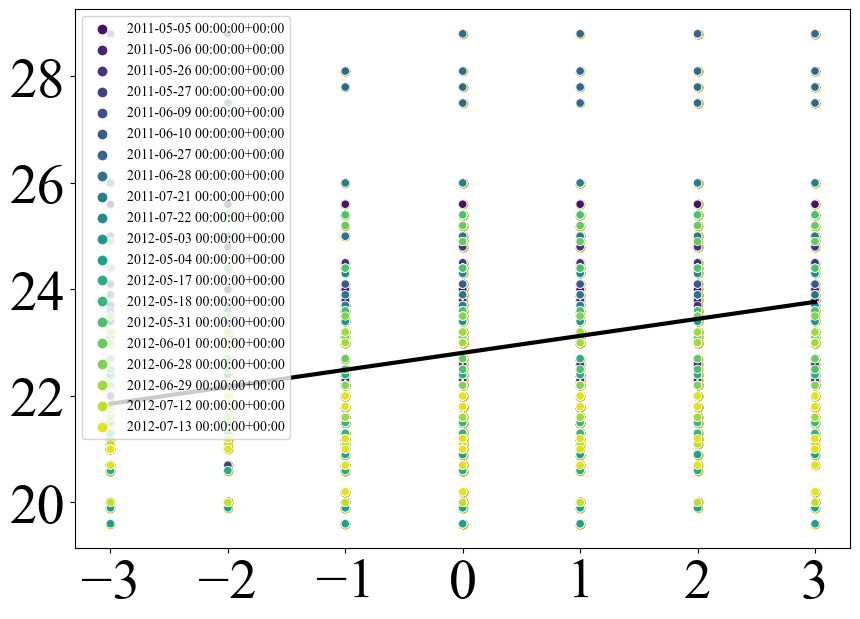

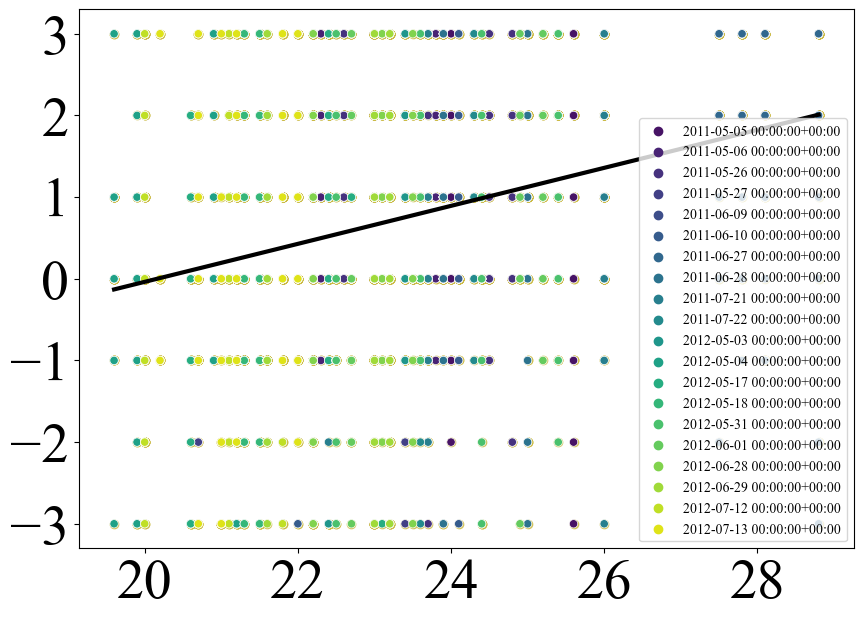

In [466]:

# scatter plot thermal indoor temperature against thermal sensation votes for the selected building, color code the timestamp
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data[df_data['building_id'] == building_id], scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)
sns.scatterplot(x='thermal_sensation', y='top', data=df_data[df_data['building_id'] == building_id], hue='timestamp', palette='viridis')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(False)
plt.legend()
plt.show()


# scatter plot thermal indoor temperature against thermal sensation votes for the selected building, color code the timestamp
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data[df_data['building_id'] == building_id], scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)
sns.scatterplot(x='top', y='thermal_sensation',data=df_data[df_data['building_id'] == building_id], hue='timestamp', palette='viridis')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(False)
plt.legend()
plt.show()

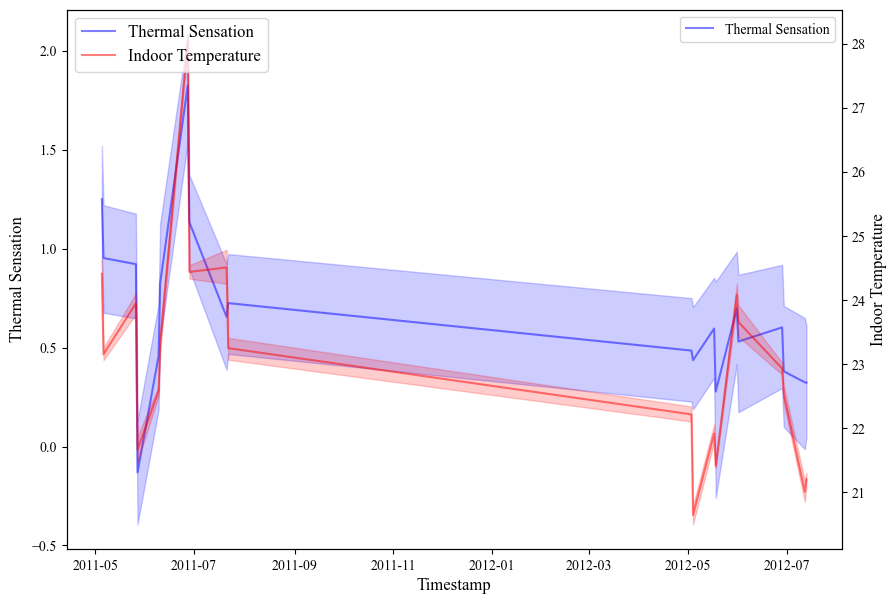

In [467]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_data is your DataFrame and building_id is defined
# Also assuming 'thermal_sensation' and 'top' are columns in your df_data DataFrame

plt.figure(figsize=(10, 7))

# Create first axis for the thermal sensation
ax1 = sns.lineplot(
    x='timestamp', 
    y='thermal_sensation', 
    data=df_data[df_data['building_id'] == building_id], 
    color='blue', 
    alpha=0.5,
    label='Thermal Sensation'  # Label for legend
)
# sns.scatterplot(
#     x='timestamp', 
#     y='thermal_sensation', 
#     data=df_data[df_data['building_id'] == building_id], 
#     color='blue',
#     alpha=0.5,
#     ax=ax1  # Specify the axis for the scatterplot
# )

# Create a second axis for the 'top' data
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
sns.lineplot(
    x='timestamp', 
    y='top', 
    data=df_data[df_data['building_id'] == building_id], 
    color='red', 
    alpha=0.5,
    ax=ax2, 
    label='Indoor Temperature'  # Label for legend
)
# sns.scatterplot(
#     x='timestamp', 
#     y='top', 
#     data=df_data[df_data['building_id'] == building_id], 
#     color='red',
#     alpha=0.5,
#     ax=ax2  # Specify the axis for the scatterplot
# )

# Set the legend for both lines and scatter plots
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

# Set x-axis and y-axis labels
ax1.set_xlabel('Timestamp', fontsize=12)
ax1.set_ylabel('Thermal Sensation', fontsize=12)
ax2.set_ylabel('Indoor Temperature', fontsize=12)

# Set font size for ticks
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Set font family
plt.rcParams['font.family'] = 'Times New Roman'

# Remove grid if you do not want it, or set it to the first axis
ax1.grid(False)

# Show the plot
plt.show()


## neutral temeprature comparasion (skip)

n_t_a
count    210.000000
mean      24.427157
std        2.847115
min       19.021124
25%       22.575175
50%       23.878357
75%       25.981671
max       33.242804
Name: n_t_a, dtype: float64
n_t_b
count    420.000000
mean      25.024018
std        4.275159
min        6.316000
25%       22.671333
50%       24.033733
75%       28.620061
max       35.490000
Name: n_t_b, dtype: float64


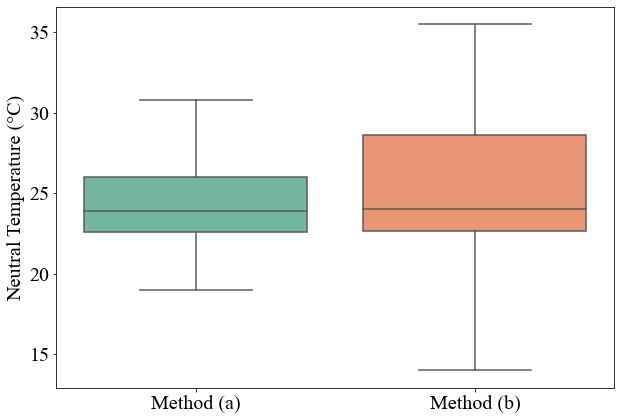

In [29]:
# boxplot of n_t_a in df_bldg_sig_a and n_t_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['n_t_a'], df_bldg_sig_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_sig_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_sig_b['n_t_b'].describe())

plt.ylabel('Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    70.000000
mean     24.289955
std       3.147114
min      19.021124
25%      22.052439
50%      23.966312
75%      26.418541
max      33.242804
Name: n_t_a, dtype: float64
n_t_b
count    150.000000
mean      26.863912
std        4.600378
min        6.316000
25%       23.931514
50%       27.922667
75%       30.288602
max       35.490000
Name: n_t_b, dtype: float64


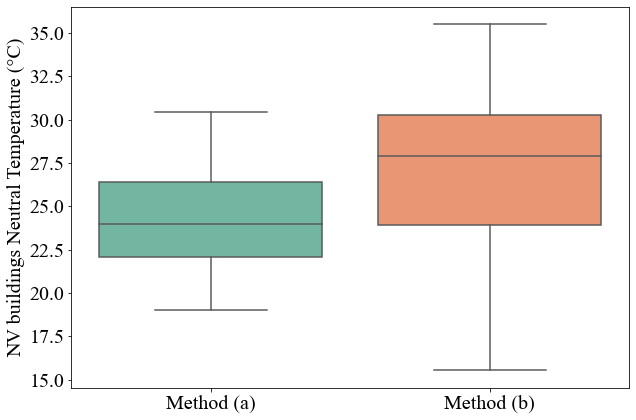

In [30]:
# NV buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_nv_a['n_t_a'], df_bldg_nv_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_nv_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_nv_b['n_t_b'].describe())

plt.ylabel('NV buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    85.000000
mean     23.926550
std       1.484819
min      21.535360
25%      22.979321
50%      23.860139
75%      24.345989
max      31.830522
Name: n_t_a, dtype: float64
n_t_b
count    146.000000
mean      23.194457
std        1.716078
min       12.775000
25%       22.685217
50%       23.335666
75%       23.909456
max       27.763548
Name: n_t_b, dtype: float64


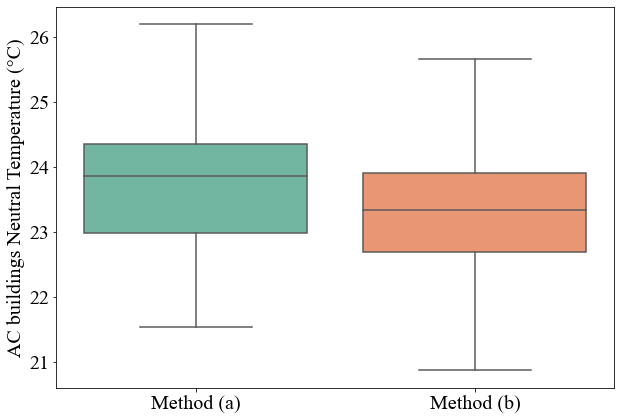

In [31]:
# AC buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_ac_a['n_t_a'], df_bldg_ac_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_ac_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_ac_b['n_t_b'].describe())

plt.ylabel('AC buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

acceptable temeprature range comparasion

t_80_up_a
count    210.000000
mean      27.668742
std        3.412919
min       21.911428
25%       25.163584
50%       26.524534
75%       29.920540
max       38.821606
Name: t_80_up_a, dtype: float64
t_80_up_b
count    421.000000
mean      25.844303
std        4.051518
min       13.100000
25%       23.157944
50%       24.749994
75%       29.516667
max       35.490000
Name: t_80_up_b, dtype: float64


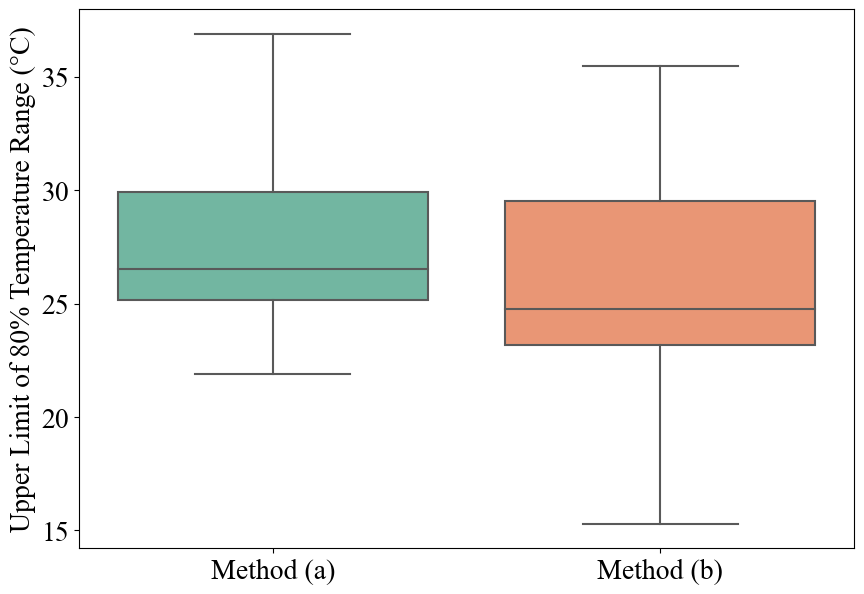

In [22]:
# boxplot of t_80_up_a in df_bldg_sig_a and t_80_up_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_up_a'], df_bldg_sig_b['t_80_up_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_up_a')
print(df_bldg_sig_a['t_80_up_a'].describe())
print('t_80_up_b')
print(df_bldg_sig_b['t_80_up_b'].describe())

plt.ylabel('Upper Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_low_a
count    210.000000
mean      21.185572
std        3.862306
min        4.465876
25%       19.191383
50%       21.601877
75%       23.125084
max       29.146479
Name: t_80_low_a, dtype: float64
t_80_low_b
count    421.000000
mean      24.198361
std        4.912291
min       -4.421200
25%       22.101421
50%       23.658147
75%       27.673333
max       35.490000
Name: t_80_low_b, dtype: float64


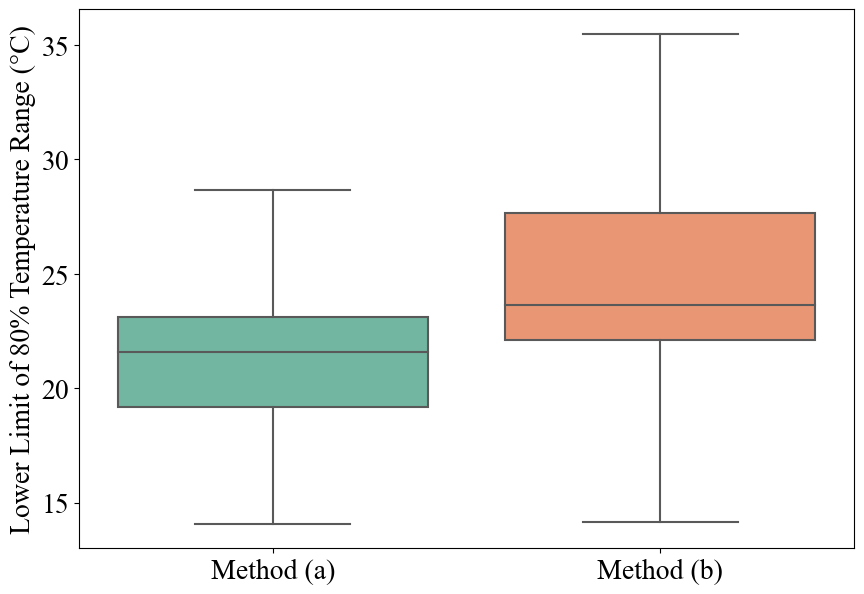

In [23]:
# boxplot of t_80_low_a in df_bldg_sig_a and t_80_low_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_low_a'], df_bldg_sig_b['t_80_low_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_low_a')
print(df_bldg_sig_a['t_80_low_a'].describe())
print('t_80_low_b')
print(df_bldg_sig_b['t_80_low_b'].describe())

plt.ylabel('Lower Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_diff_a
count    210.000000
mean       6.483170
std        4.550449
min        0.034000
25%        3.419248
50%        5.435545
75%        8.369759
max       29.110494
Name: t_80_diff_a, dtype: float64
t_80_diff_b
count    421.000000
mean       1.645942
std        2.853907
min        0.000000
25%        0.212053
50%        0.694763
75%        2.078316
max       26.422250
Name: t_80_diff_b, dtype: float64


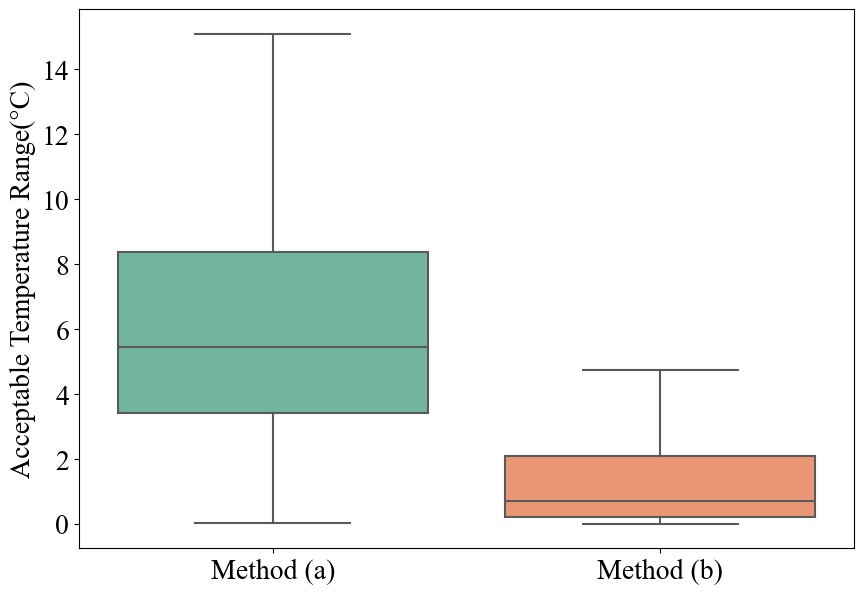

In [24]:
# boxplot of t_80_diff_a in df_bldg_sig_a and t_80_diff_b in df_bldg_sig_b, don't show outliers
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_diff_a'], df_bldg_sig_b['t_80_diff_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_diff_a')
print(df_bldg_sig_a['t_80_diff_a'].describe())
print('t_80_diff_b')
print(df_bldg_sig_b['t_80_diff_b'].describe())

plt.ylabel('Acceptable Temperature Range(°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()


In [25]:
# how many buildings have a negative coefficient for the regression of thermal sensation against temperature


## Adaptive comfort model (natural ventilated buildings)

In [854]:
# Weighted regression function
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    # print p value of slope
    print('the p value of slope is {:.3f}'.format(model.pvalues[1]))
    print('the weigted regression fitted line slope (a) a is {:.2f}'.format(slope))
    print('the weigted regression fitted line intercept (b) is {:.2f}'.format(intercept))
    print(model.summary())
    return intercept, slope

method a

In [855]:
len(df_bldg_nv_a)

47

In [856]:
# only keep office buildings
df_bldg_nv_a = df_bldg_nv_a[df_bldg_nv_a['building_type'] == 'office'].copy()
len(df_bldg_nv_a)

47

In [857]:
# drop buildings with t_out_combined > 35 or < 10
df_bldg_nv_a = df_bldg_nv_a[df_bldg_nv_a['t_out_combined'] <= 35]
df_bldg_nv_a = df_bldg_nv_a[df_bldg_nv_a['t_out_combined'] >= 10]
len(df_bldg_nv_a)


47

In [858]:
middle_a_intercept, middle_a_slope = weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], df_bldg_nv_a['records'])
up_a_intercept, up_a_slope = weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_up_a'], df_bldg_nv_a['records'])
low_a_intercept, low_a_slope= weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_low_a'], df_bldg_nv_a['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.28
the weigted regression fitted line intercept (b) is 18.28
                            WLS Regression Results                            
Dep. Variable:                  n_t_a   R-squared:                       0.560
Model:                            WLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     57.22
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.50e-09
Time:                        21:10:28   Log-Likelihood:                -93.630
No. Observations:                  47   AIC:                             191.3
Df Residuals:                      45   BIC:                             195.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.

In [859]:
# calculate the average value of t_80_up_a and t_80_low_a, t_80_diff_b
n_a = df_bldg_nv_a['n_t_a'].mean()
up_a = df_bldg_nv_a['t_80_up_a'].mean()
low_a = df_bldg_nv_a['t_80_low_a'].mean()
range_a = df_bldg_nv_a['t_80_diff_a'].mean()
print("mean neutral temp using A:", n_a)
print("mean upper and lower limits:",up_a, low_a)
print("mean range:", range_a)

mean neutral temp using A: 23.952172219210954
mean upper and lower limits: 27.795121312339397 20.109223126082515
mean range: 7.685898186256884


(5.0, 35.0)

<Figure size 1000x700 with 0 Axes>

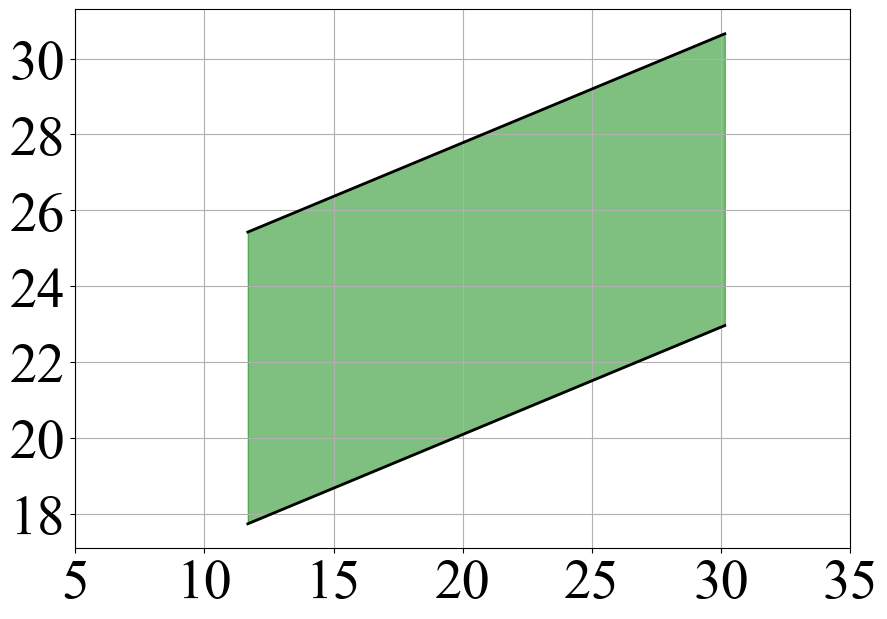

In [805]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_a_slope*t_out_combined+middle_a_intercept+range_a/2)[sort_index]
low_line = (middle_a_slope*t_out_combined+middle_a_intercept-range_a/2)[sort_index]


# draw green band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
# plt.title('Naturally ventilated buildings using method a', fontsize=40)

# # set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
# plt.ylim(16, 34)


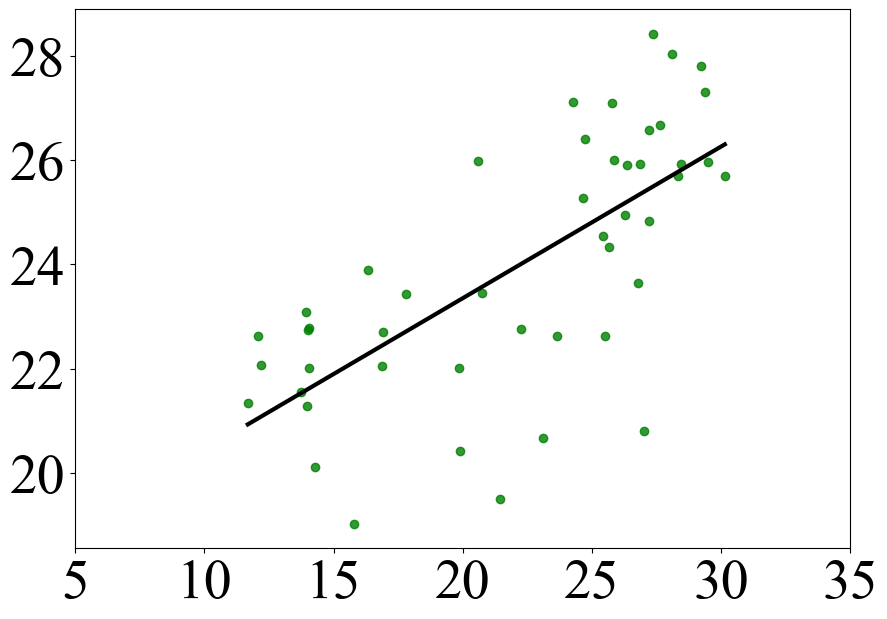

In [852]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_a', data=df_bldg_nv_a, scatter_kws={'color': 'green'}, line_kws={'color': 'black', 'linewidth': 3}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=26)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(5, 35)
# plt.ylim(16, 34)

plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'

(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

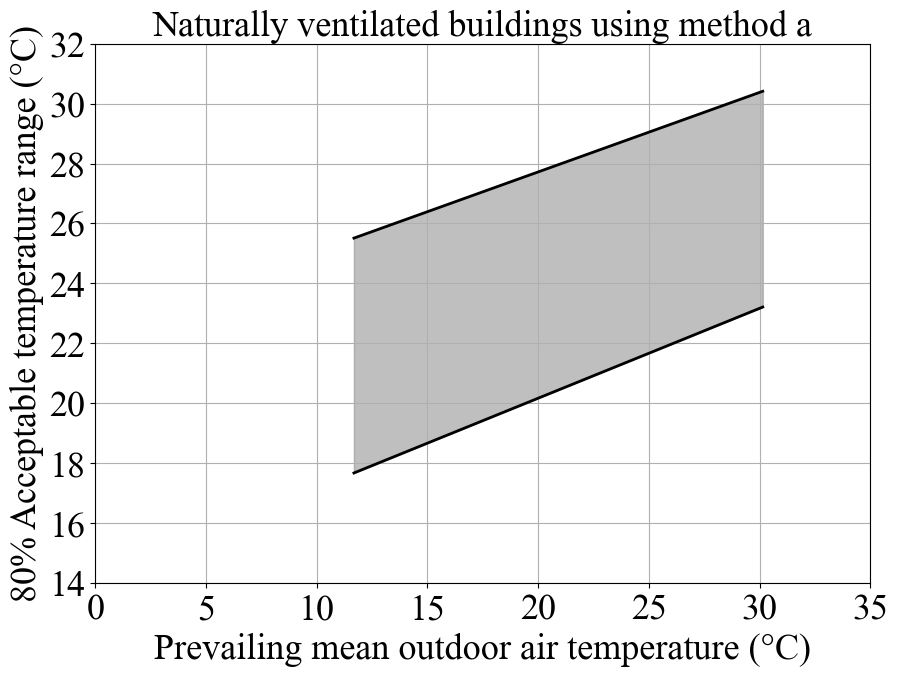

In [864]:
# true upper and lower regression lines
# plot two lines, one with the up_a_slope and up_a_intercept, and another with the low_a_slope and low_a_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_a_slope*t_out_combined + up_a_intercept)[sort_index]
low_line = (low_a_slope*t_out_combined + low_a_intercept)[sort_index]


# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, color='black', linewidth=2)
# plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_a_slope*t_out_combined+low_a_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, low_a_slope*t_out_combined+low_a_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Naturally ventilated buildings using method a', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)


#mse

In [873]:
# calculate mean squared error (MSE) for the regression line
def mse(x, y, intercept, slope):
    y_pred = slope*x + intercept
    mse = np.mean((y-y_pred)**2)
    return mse

mse(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], middle_a_intercept, middle_a_slope)

3.3889089281685845

method b

In [866]:
# only keep office buildings
df_bldg_nv_b = df_bldg_nv_b[df_bldg_nv_b['building_type'] == 'office'].copy()
len(df_bldg_nv_b)

47

In [867]:
# drop buildings with t_out_combined > 35 or < 10
df_bldg_nv_b = df_bldg_nv_b[df_bldg_nv_b['t_out_combined'] <= 35]
df_bldg_nv_b = df_bldg_nv_b[df_bldg_nv_b['t_out_combined'] >= 10]
len(df_bldg_nv_b)


47

In [868]:
middle_b_intercept, middle_b_slope = weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['n_t_b'], df_bldg_nv_b['records'])
up_b_intercept, up_b_slope = weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_up_b'], df_bldg_nv_b['records'])
low_b_intercept, low_b_slope= weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_low_b'], df_bldg_nv_b['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.49
the weigted regression fitted line intercept (b) is 15.22
                            WLS Regression Results                            
Dep. Variable:                  n_t_b   R-squared:                       0.822
Model:                            WLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     208.2
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.71e-18
Time:                        23:10:32   Log-Likelihood:                -88.686
No. Observations:                  47   AIC:                             181.4
Df Residuals:                      45   BIC:                             185.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.

In [869]:
n_b = df_bldg_nv_b['n_t_b'].mean()
up_b = df_bldg_nv_b['t_80_up_b'].mean()
low_b = df_bldg_nv_b['t_80_low_b'].mean()
range_b = df_bldg_nv_b['t_80_diff_b'].mean()
print("mean neutral temp using B", n_b)
print("mean upper and lower limits:",up_b, low_b)
print("mean range:", range_b)

mean neutral temp using B 25.67368121595632
mean upper and lower limits: 26.534966455961225 24.812395975951418
mean range: 1.7225704800098023


(5.0, 35.0)

<Figure size 1000x700 with 0 Axes>

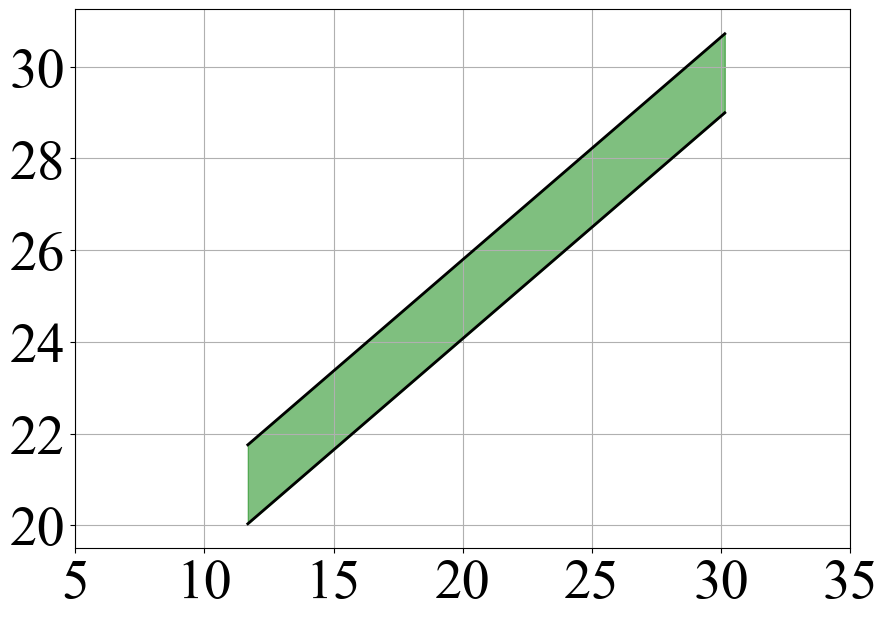

In [870]:
# plot the same diagram as ACM
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_b_slope*t_out_combined+middle_b_intercept+range_b/2)[sort_index]
low_line = (middle_b_slope*t_out_combined+middle_b_intercept-range_b/2)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='black', linewidth=2)

plt.fill_between(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

# plt.title('naturally ventialted buildings using method b', fontsize=40)
plt.grid(True)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
# plt.ylim(18, 34)



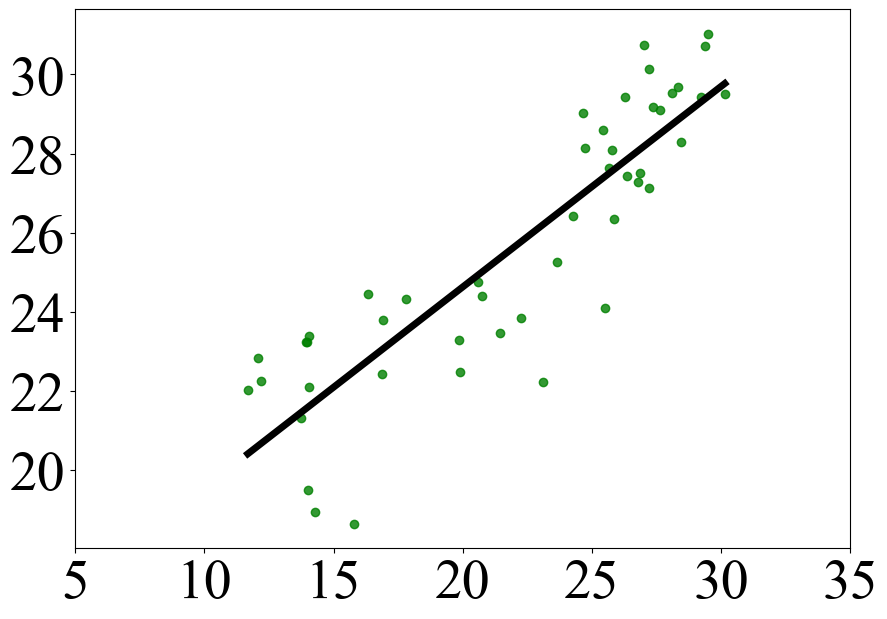

In [871]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_b', data=df_bldg_nv_b, scatter_kws={'color': 'green'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(5, 35)
# plt.ylim(16, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'


(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

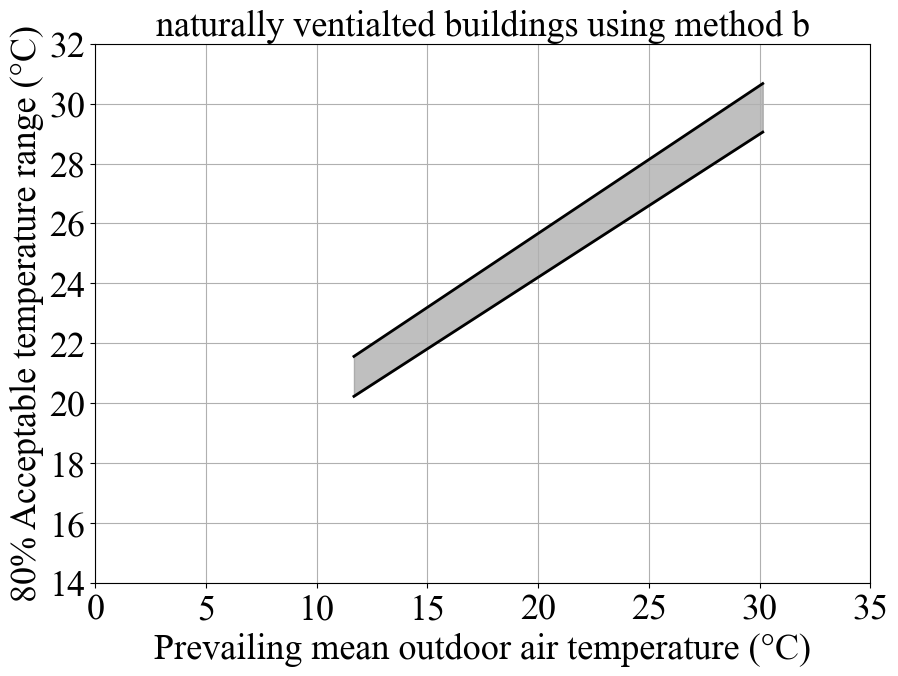

In [872]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
# plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable temperature range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.title('naturally ventialted buildings using method b', fontsize=26)
plt.grid(True)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



#mse

In [874]:
mse(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['n_t_b'], middle_b_intercept, middle_b_slope)

2.7109658446923937

## Adaptive model in all buildings

In [142]:
# drop buildings with t_out_combined > 35 or < 10
df_bldg_sig_a = df_bldg_sig_a[df_bldg_sig_a['t_out_combined'] <= 35]
df_bldg_sig_a = df_bldg_sig_a[df_bldg_sig_a['t_out_combined'] >= 10]

middle_a_intercept, middle_a_slope = weighted_regression(df_bldg_sig_a['t_out_combined'], df_bldg_sig_a['n_t_a'], df_bldg_sig_a['records'])
up_a_intercept, up_a_slope = weighted_regression(df_bldg_sig_a['t_out_combined'], df_bldg_sig_a['t_80_up_a'], df_bldg_sig_a['records'])
low_a_intercept, low_a_slope= weighted_regression(df_bldg_sig_a['t_out_combined'], df_bldg_sig_a['t_80_low_a'], df_bldg_sig_a['records'])

# calculate the average value of t_80_up_a and t_80_low_a, t_80_diff_b
n_a = df_bldg_sig_a['n_t_a'].mean()
up_a = df_bldg_sig_a['t_80_up_a'].mean()
low_a = df_bldg_sig_a['t_80_low_a'].mean()
range_a = df_bldg_sig_a['t_80_diff_a'].mean()
print("mean neutral temp using A:", n_a)
print("mean upper and lower limits:",up_a, low_a)
print("mean range:", range_a)


the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.23
the weigted regression fitted line intercept (b) is 19.31
the p value of slope is 0.001
the weigted regression fitted line slope (a) a is 0.20
the weigted regression fitted line intercept (b) is 23.33
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.26
the weigted regression fitted line intercept (b) is 15.29
mean neutral temp using A: 23.799315596634433
mean upper and lower limits: 25.86969648903655 21.728934704232323
mean range: 4.1407617848042255


(18.0, 30.0)

<Figure size 1000x700 with 0 Axes>

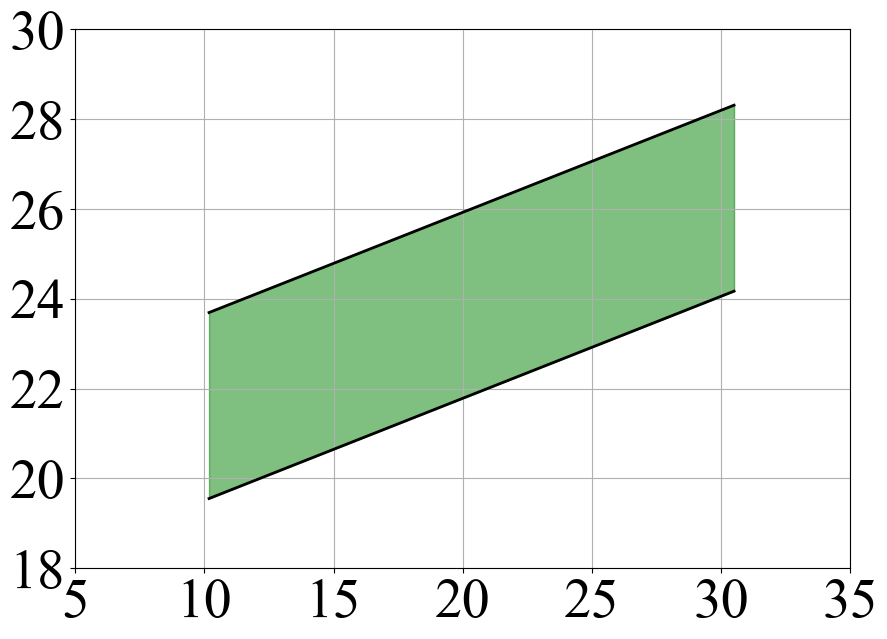

In [143]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_sig_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_a_slope*t_out_combined+middle_a_intercept+range_a/2)[sort_index]
low_line = (middle_a_slope*t_out_combined+middle_a_intercept-range_a/2)[sort_index]


# draw green band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
# plt.title('Naturally ventilated buildings using method a', fontsize=40)

# # set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
plt.ylim(18, 30)


method b

In [144]:
# drop buildings with t_out_combined > 35 or < 10
df_bldg_sig_b = df_bldg_sig_b[df_bldg_sig_b['t_out_combined'] <= 35]
df_bldg_sig_b = df_bldg_sig_b[df_bldg_sig_b['t_out_combined'] >= 10]

middle_b_intercept, middle_b_slope = weighted_regression(df_bldg_sig_b['t_out_combined'], df_bldg_sig_b['n_t_b'], df_bldg_sig_b['records'])
up_b_intercept, up_b_slope = weighted_regression(df_bldg_sig_b['t_out_combined'], df_bldg_sig_b['t_80_up_b'], df_bldg_sig_b['records'])
low_b_intercept, low_b_slope= weighted_regression(df_bldg_sig_b['t_out_combined'], df_bldg_sig_b['t_80_low_b'], df_bldg_sig_b['records'])

# calculate the average value of t_80_up_b and t_80_low_b, t_80_diff_b
n_b = df_bldg_sig_b['n_t_b'].mean()
up_b = df_bldg_sig_b['t_80_up_b'].mean()
low_b = df_bldg_sig_b['t_80_low_b'].mean()
range_b = df_bldg_sig_b['t_80_diff_b'].mean()
print("mean neutral temp using A:", n_b)
print("mean upper and lower limits:",up_b, low_b)
print("mean range:", range_b)

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.32
the weigted regression fitted line intercept (b) is 17.59
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.33
the weigted regression fitted line intercept (b) is 17.94
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.31
the weigted regression fitted line intercept (b) is 17.23
mean neutral temp using A: 24.00039498834954
mean upper and lower limits: 24.43223524674522 23.568554729953878
mean range: 0.863680516791341


(18.0, 30.0)

<Figure size 1000x700 with 0 Axes>

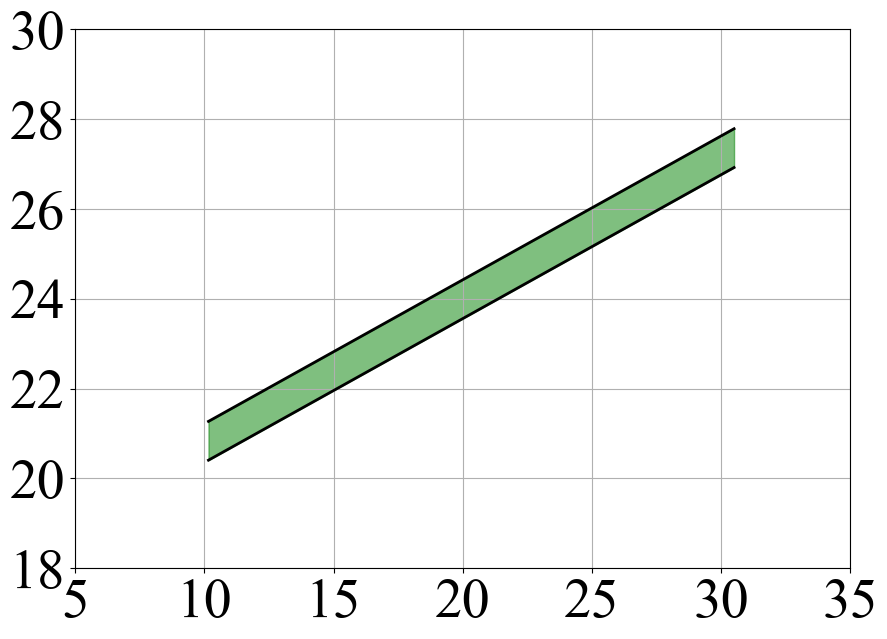

In [146]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_sig_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_b_slope*t_out_combined+middle_b_intercept+range_b/2)[sort_index]
low_line = (middle_b_slope*t_out_combined+middle_b_intercept-range_b/2)[sort_index]


# draw green band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
# plt.title('Naturally ventilated buildings using method a', fontsize=40)

# # set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
plt.ylim(18, 30)


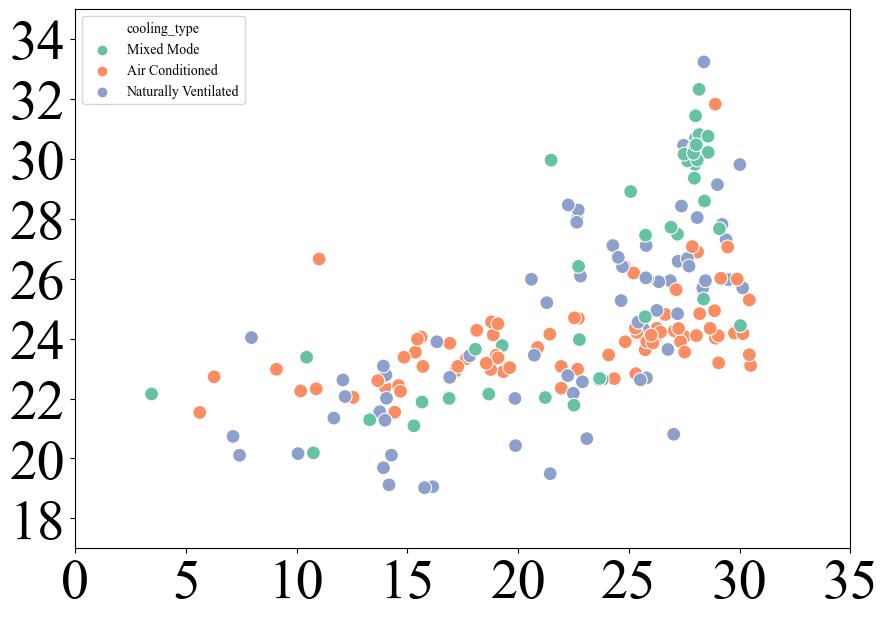

In [90]:
#show air conditioned buildings as blue dots and naturally ventilated buildings as red dots
plt.figure(figsize=(10, 7))
sns.scatterplot(x='t_out_combined', y='n_t_a', data=df_bldg_sig_a, hue='cooling_type', palette='Set2', s=100)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(0, 35)
plt.ylim(17, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'



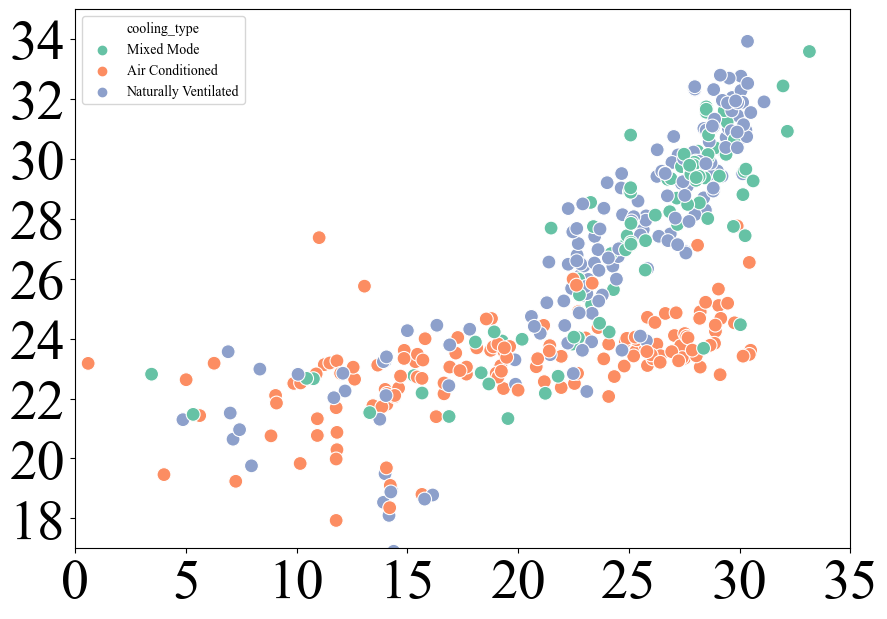

In [91]:
#show air conditioned buildings as blue dots and naturally ventilated buildings as red dots
plt.figure(figsize=(10, 7))
sns.scatterplot(x='t_out_combined', y='n_t_b', data=df_bldg_sig_b, hue='cooling_type', palette='Set2', s=100)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(0, 35)
plt.ylim(17, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'

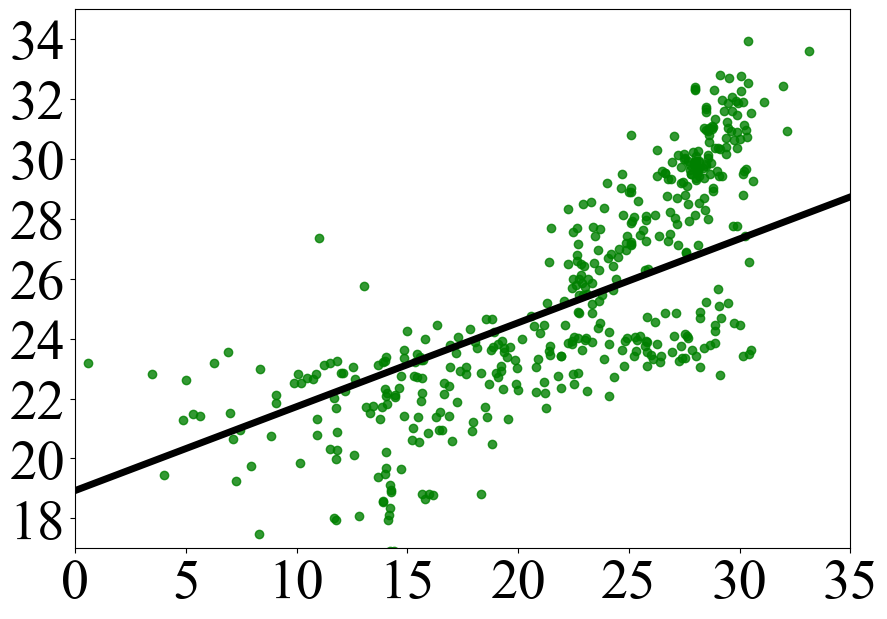

In [89]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_b', data=df_bldg_sig_b, scatter_kws={'color': 'green'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(0, 35)
plt.ylim(17, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'


Try SET

In [36]:
cols = ['t_out_combined', 'set', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 518 ['t_out_combined', 'set', 'thermal_sensation']
Qualified records: 26307


In [37]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ set', data=bldg).fit()
        slope = lm_result.params['set']
        # check whether the slope is significant
        if lm_result.pvalues['set'] < 0.05:
            a = lm_result.params['set']
            b = lm_result.params['Intercept']
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='set ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            a = lm_result.params['thermal_sensation']
            b = lm_result.params['Intercept']
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

In [38]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'set', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,set,t_out_combined,records,cooling_type,building_type
0,1,23.171127,25.454225,15.560695,170,Mixed Mode,office
1,2,22.081333,23.616000,13.995833,83,Air Conditioned,office
2,3,23.145098,23.694118,0.583480,85,Air Conditioned,office
3,4,23.673109,24.164706,19.225391,137,Mixed Mode,office
4,5,22.062500,22.271875,9.048210,128,Air Conditioned,office


In [39]:
# calculate all temperature values for each building
columns_name = ['slope', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

# calculate the mean of the absolute difference between t_80_up_a and t_80_low_a
df_bldg['t_80_diff_a'] = df_bldg['t_80_up_a'] - df_bldg['t_80_low_a']
df_bldg['t_80_diff_b'] = df_bldg['t_80_up_b'] - df_bldg['t_80_low_b']

df_bldg.head()

,building_id,ta,set,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_80_diff_a,t_80_diff_b
0,1,23.171127,25.454225,15.560695,170,Mixed Mode,office,0.291385,0.872775,23.182414,24.876473,26.099516,25.618332,20.265312,24.134614,24.898357,25.312860,5.834205,1.483717
1,2,22.081333,23.616000,13.995833,83,Air Conditioned,office,NaN,0.223873,NaN,23.611523,NaN,23.801815,NaN,23.421230,NaN,23.723459,NaN,0.380585
2,3,23.145098,23.694118,0.583480,85,Air Conditioned,office,NaN,0.130253,NaN,23.661171,NaN,23.771887,NaN,23.550456,NaN,23.726298,NaN,0.221431
3,4,23.673109,24.164706,19.225391,137,Mixed Mode,office,0.211156,0.483831,23.806534,24.128114,27.831991,24.539370,19.781077,23.716858,26.174450,24.370029,8.050914,0.822512
4,5,22.062500,22.271875,9.048210,128,Air Conditioned,office,NaN,0.338823,NaN,22.293316,NaN,22.581316,NaN,22.005317,NaN,22.462728,NaN,0.575999


In [40]:
# create a buliding id list for buildings with negative slope_a or slope_b
bldg_id_neg = df_bldg[(df_bldg['slope_a'] < 0) | (df_bldg['slope_b'] < 0)]['building_id'].tolist()
# remove the buildings of bldg_id_neg from df_bldg
df_bldg = df_bldg[~df_bldg['building_id'].isin(bldg_id_neg)].copy()

In [41]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]

print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

df_bldg_ac_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 129
number of naturally ventilated buildings that have statistical significant neutral temperature: 56
number of air conditioned buildings that have statistical significant neutral temperature: 37


In [42]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]

print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))

df_bldg_ac_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_b))

df_bldg_re_b = df_bldg_sig_b[df_bldg_sig_b['building_type'] == 'multifamily housing']
print('number of multi-family buildings that have statistical significant neutral temperature:', len(df_bldg_re_b))


regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 350
number of naturally ventilated buildings that have statistical significant neutral temperature: 128
number of air conditioned buildings that have statistical significant neutral temperature: 114
number of multi-family buildings that have statistical significant neutral temperature: 177


(14.0, 32.0)

<Figure size 1000x700 with 0 Axes>

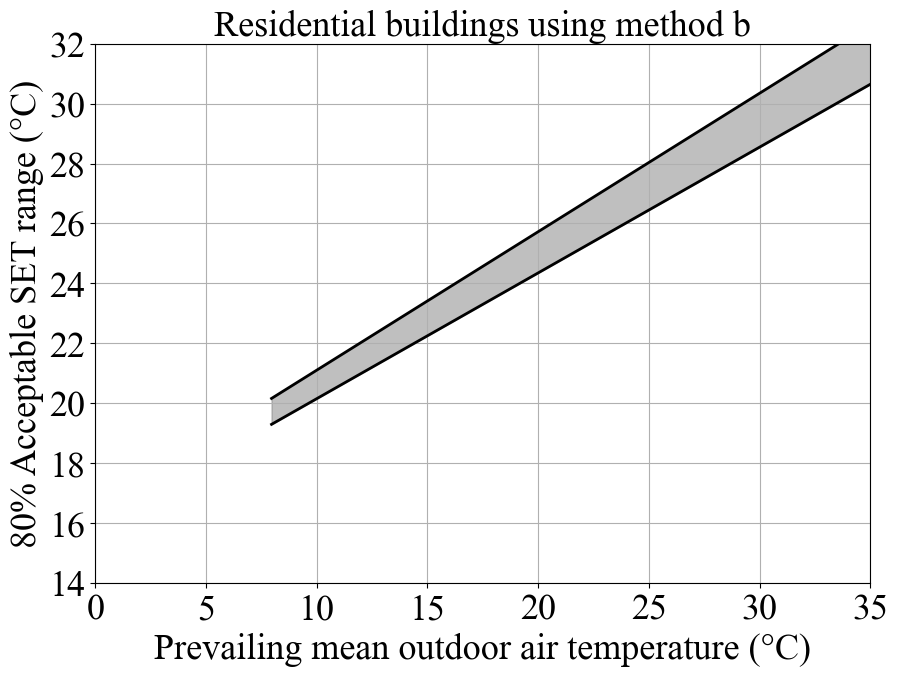

In [43]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_re_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=26)
plt.ylabel("80% Acceptable SET range (°C)", rotation=90, fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(True)
plt.title('Residential buildings using method b', fontsize=26)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



## Graph

/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_51032/2790564676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])


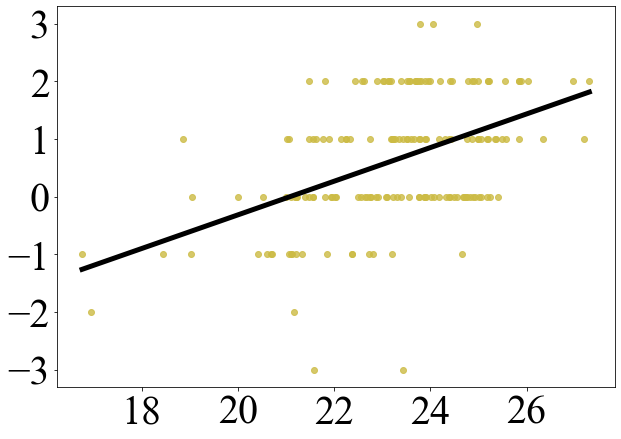

In [68]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='thermal_sensation ~ top', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black','linewidth': 5}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
# plt.title('Regress thermal sensation votes on indoor temperature')
# change the font to sen-serif Times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.06, 0.8)
# alighn label right in the text box
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels

plt.savefig('case1a.pdf', format='pdf', bbox_inches='tight')
plt.grid(False)
plt.show()


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_51032/3494540287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])


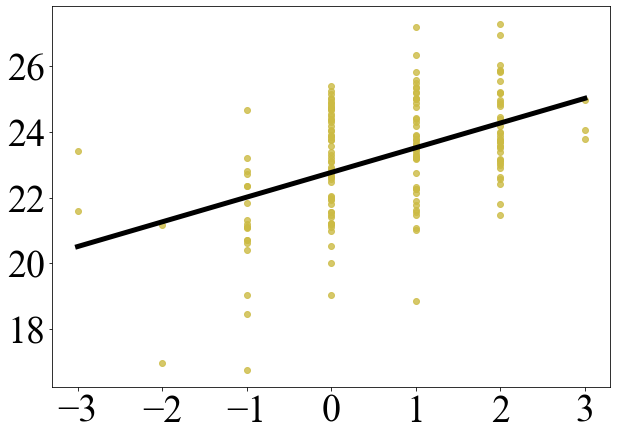

In [69]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='top ~ thermal_sensation', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])
# plot the regression line, don't show the confidence interval
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)

plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# plt.title('Regress thermal sensation votes on indoor temperature')
plt.rcParams['font.family'] = 'Times New Roman'

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(1, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.72)
ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.xticks(fontsize=38)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=38)  # Set font size for y-axis tick labels

plt.grid(False)
plt.savefig('case1b.pdf', format='pdf', bbox_inches='tight')
plt.show()

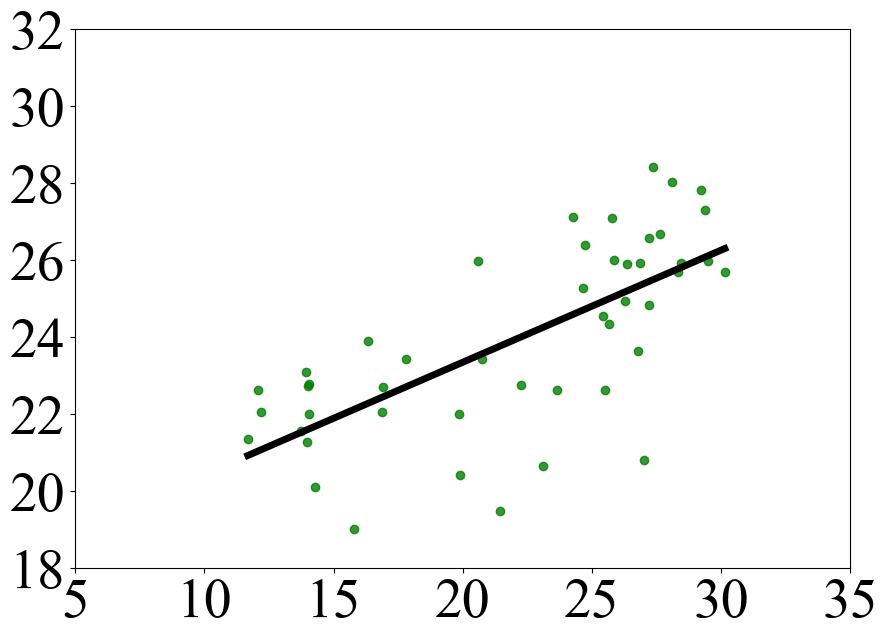

In [828]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_a', data=df_bldg_nv_a, scatter_kws={'color': 'green'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=26)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(5, 35)
plt.ylim(18, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('ACMlinea.pdf', format='pdf', bbox_inches='tight')

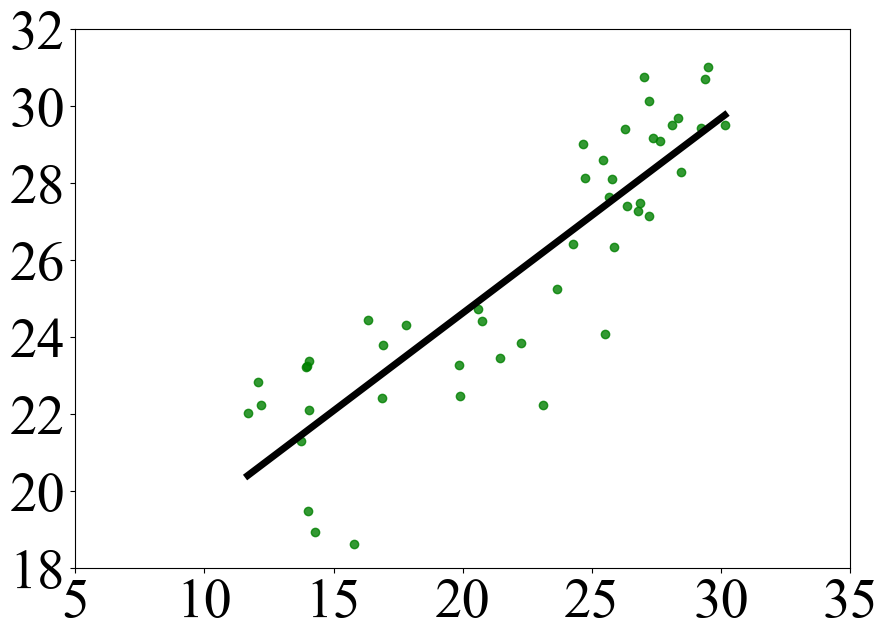

In [827]:
# plot the data points and the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='n_t_b', data=df_bldg_nv_b, scatter_kws={'color': 'green'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(5, 35)
plt.ylim(18, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('ACMlineb.pdf', format='pdf', bbox_inches='tight')

<Figure size 1000x700 with 0 Axes>

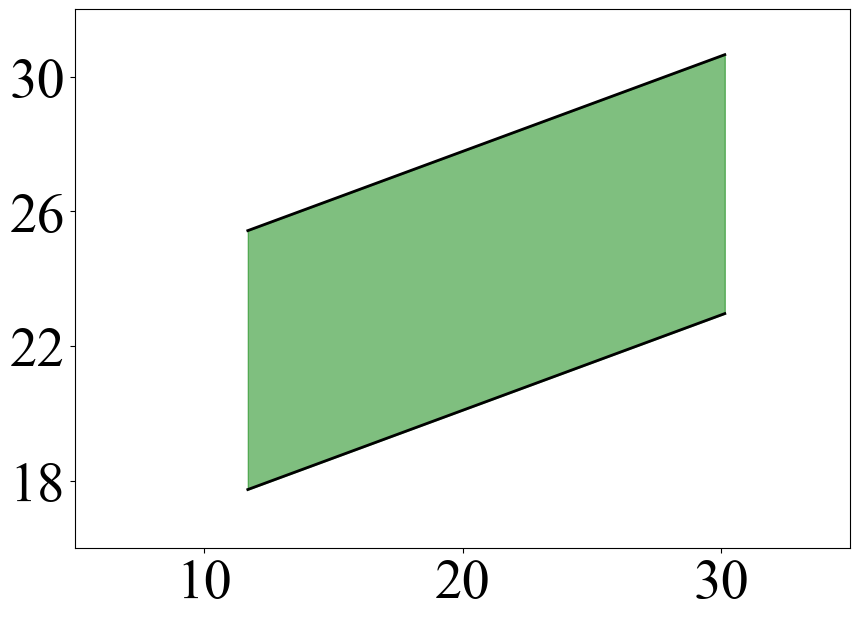

In [843]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_a_slope*t_out_combined+middle_a_intercept+range_a/2)[sort_index]
low_line = (middle_a_slope*t_out_combined+middle_a_intercept-range_a/2)[sort_index]


# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks([10, 20, 30], fontsize=40)
plt.yticks([18, 22, 26, 30], fontsize=40)
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlim(5, 35)
plt.ylim(16, 32)
# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

plt.grid(False)
# plt.title('Naturally ventilated buildings using method a', fontsize=40)
plt.savefig('ACMa.pdf', format='pdf', bbox_inches='tight')

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32


<Figure size 1000x700 with 0 Axes>

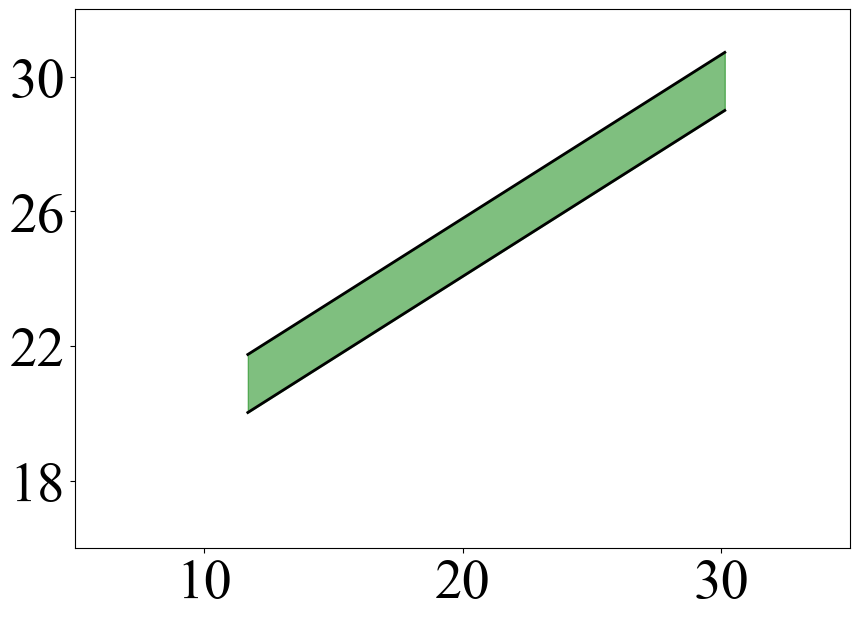

In [844]:
# plot the same diagram as ACM
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_b_slope*t_out_combined+middle_b_intercept+range_b/2)[sort_index]
low_line = (middle_b_slope*t_out_combined+middle_b_intercept-range_b/2)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks([10, 20, 30], fontsize=40)
plt.yticks([18, 22, 26, 30], fontsize=40)
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlim(5, 35)
plt.ylim(16, 32)
# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right

# plt.title('naturally ventialted buildings using method b', fontsize=40)
plt.grid(False)
plt.savefig('ACMb.pdf', format='pdf', bbox_inches='tight')
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32




<Figure size 1000x700 with 0 Axes>

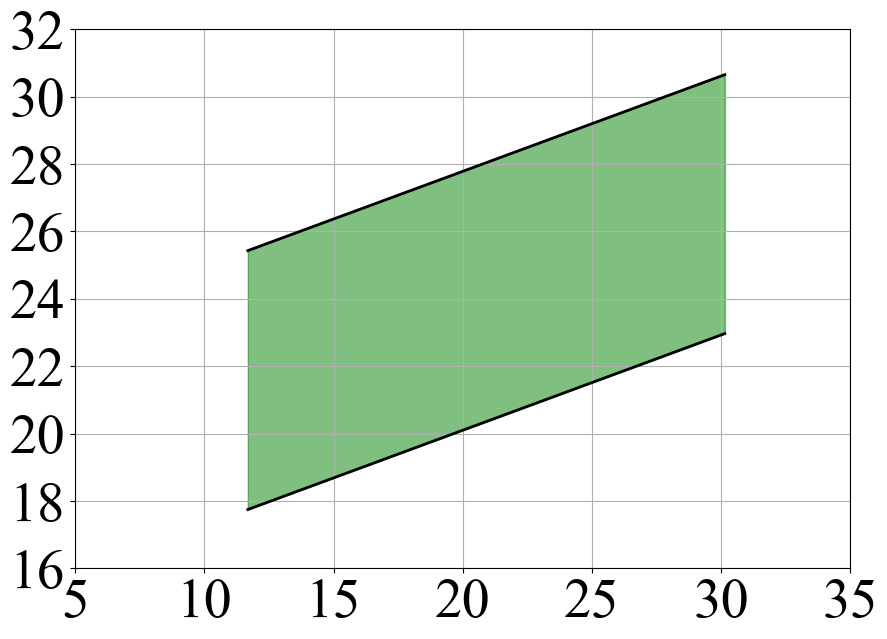

In [850]:
# plot the same diagram as ACM, with constant range
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_a_slope*t_out_combined+middle_a_intercept+range_a/2)[sort_index]
low_line = (middle_a_slope*t_out_combined+middle_a_intercept-range_a/2)[sort_index]


# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='black', linewidth=2)
plt.fill_between(t_out_combined, middle_a_slope*t_out_combined+middle_a_intercept+range_a/2, middle_a_slope*t_out_combined+middle_a_intercept-range_a/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(list(range(0, 36, 5)), fontsize=40)
plt.yticks(list(range(14, 33, 2)),fontsize=40)
plt.rcParams['font.family'] = 'Times New Roman'

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
plt.ylim(16, 32)

plt.grid(True)
# plt.title('Naturally ventilated buildings using method a', fontsize=40)
plt.savefig('ACMgrida.pdf', format='pdf', bbox_inches='tight')


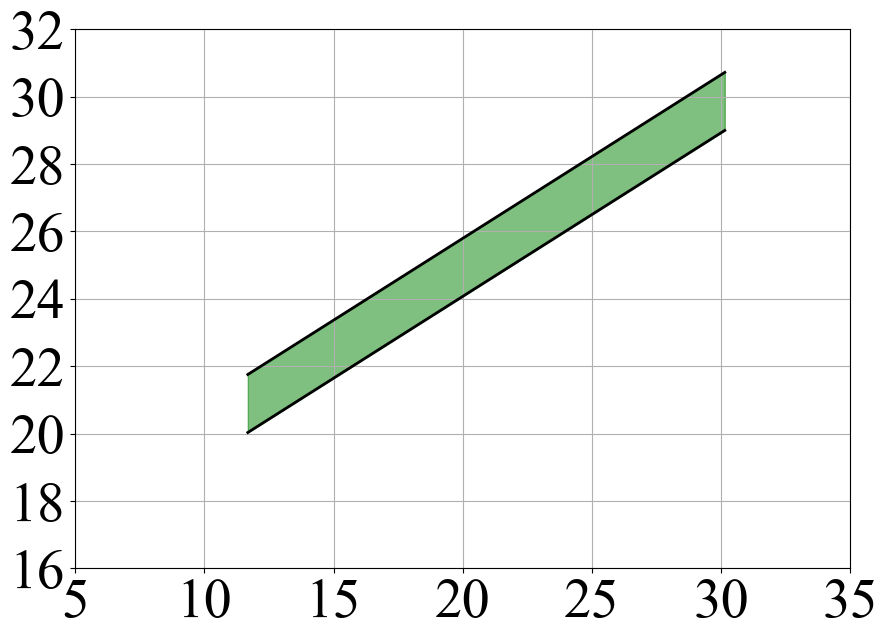

In [851]:
# plot the same diagram as ACM
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (middle_b_slope*t_out_combined+middle_b_intercept+range_b/2)[sort_index]
low_line = (middle_b_slope*t_out_combined+middle_b_intercept-range_b/2)[sort_index]

plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, color='black', linewidth=2)
plt.plot(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='black', linewidth=2)

plt.fill_between(t_out_combined, middle_b_slope*t_out_combined+middle_b_intercept+range_b/2, middle_b_slope*t_out_combined+middle_b_intercept-range_b/2, color='green', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel("", rotation=90, fontsize=40)
plt.xticks(list(range(0, 36, 5)), fontsize=40)
plt.yticks(list(range(14, 33, 2)),fontsize=40)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'

# # Move y-axis label to the top and adjust the distance
# ax = plt.gca()
# ax.xaxis.set_label_coords(1, -0.1)
# ax.yaxis.set_label_coords(-0.08, 1)
# # alighn label right in the text box
# ax.yaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# ax.xaxis.get_label().set_ha('right')  # this line is added for horizontal alignment to the right
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(5, 35)
plt.ylim(16, 32)

# plt.title('naturally ventialted buildings using method b', fontsize=40)
plt.savefig('ACMgridb.pdf', format='pdf', bbox_inches='tight')


